In [104]:
import csv
from pathlib import Path
import os
from matplotlib import pyplot as plt
import numpy as np
import torch
import gpytorch
import glob
from tqdm.notebook import tqdm
import os
from numpy import genfromtxt
import time
import scipy
import pandas as pd

torch.__version__

'1.13.0+cu117'

In [105]:
#              0       1      2    3     4     5    6    7      8     9       10       11        12
#           safety throttle steer curr volt   ax   ay    w    v_enc  time   x_opti   y_opti  theta_opti
train_inputs_indexes = [ 1, 2, 5, 6, 7 ]
train_outputs_indexes = [ 5, 6, 7]

# filtering data parameters

dt = 0.1
time_step = 0.1

cut_off_freq_w = 1
cut_off_freq_vx = 0.4
cut_off_freq_vy = 0.4

# Length of the Jetracer
L = 0.175   
m = 1.63
Iz = 0.0061
lr = 0.45*L
lf = L - lr
dt = 0.1

# Plot Data in order to find similar batches

In [106]:
# path_to_folder = Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings')
# # path_to_folder = Path('/home/riccardo/GitHub_repo/GPs_for_macchinine/Codice_Lyons/GP_MPCC_ROS_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings')
# all_files = path_to_folder.glob("*.csv")
# for filename in all_files:
#     data_numpy = genfromtxt(filename, delimiter=',', skip_header=1) # extract data into a numpy array
    
    
    

In [107]:
# batch con basse velocità su cui fare training
file_name_train = Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/rec_mod_17_41_22.csv')

# batch per fare training ad alte velocità
# file_name_train = Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/rec_mod_17_36_04.csv')

# batch basse velocità donut
# file_name_train = Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/rec_mod_17_45_42.csv')

# batch molto lungo
file_name_train = Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/rec_mod_17_30_18.csv')

# batch simulato
# file_name_train = Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/sim_rec.csv')

# batch simulato a LOW SPEED
# file_name_train = Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/low_speed.csv')

# ennesimo esperimento di simulazione low speed
# file_name_train = Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/exp_low_speed.csv')

# ennesimo esperimento di simulazione high speed
# file_name_train = Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/exp_high_speed.csv'')

# LOW SPEED simulazione con modello che utilizza parametri che fittano sia low che high speed
# file_name_train = Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/recording_02_15_2023_12_12_27.csv')
# file_name_train = Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/recording_02_15_2023_14_48_32.csv')

# HIGH SPEED simulazione con modello che utilizza parametri che fittano sia low che high speed
# file_name_train = Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/recording_02_15_2023_17_28_45.csv')

# RANDOM set
# file_name_train = Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/randm_set.csv')

# RANDOM set 2
# file_name_train = Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/randm_set2.csv')



data_numpy_train = genfromtxt(file_name_train, delimiter=',', skip_header=1)

if file_name_train == Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/rec_mod_17_36_04.csv'):
    data_numpy_train = data_numpy_train[:1000,:]

data_numpy_train.shape

if np.mod(data_numpy_train.shape[0],2)!=0:
    data_numpy_train = data_numpy_train[:-1,:]

# data_numpy_train = data_numpy_train[:700,:]

In [108]:
# batch con velocità comparabili al training
file_name_test = Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/rec_mod_17_16_41.csv')

# batch con velocità molto più alte
# file_name_test = Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/rec_mod_17_53_07.csv')

# batch alte velocità donut
# file_name_test = Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/rec_mod_17_49_27.csv')

# batch con velocità MEDIO-ALTA
# file_name_test = Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/rec_mod_17_36_04.csv')

# batch molto lungo
file_name_test = Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/rec_mod_17_30_18.csv')

# batch con basse velocità su cui fare training
# file_name_test = Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/rec_mod_17_41_22.csv')

# batch simulato
# file_name_test = Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/sim_rec.csv')

# batch simulato a LOW SPEED
# file_name_test = Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/low_speed.csv')

# ennesimo esperimento di simulazione low speed
# file_name_test = Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/exp_low_speed.csv')

# ennesimo esperimento di simulazione high speed
# file_name_test = Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/exp_high_speed.csv'')

# LOW SPEED simulazione con modello che utilizza parametri che fittano sia low che high speed
# file_name_test = Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/recording_02_15_2023_12_12_27.csv')
# file_name_test = Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/recording_02_15_2023_14_48_32.csv')

# HIGH SPEED simulazione con modello che utilizza parametri che fittano sia low che high speed
# file_name_test = Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/recording_02_15_2023_17_28_45.csv')

# RANDOM set
# file_name_test = Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/randm_set.csv')

# RANDOM set 2
# file_name_test = Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/randm_set2.csv')

                      
data_numpy_test = genfromtxt(file_name_test, delimiter=',', skip_header=1)

if file_name_test == Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/rec_mod_17_53_07.csv'):
    data_numpy_test = data_numpy_test[:300,:]
    
if file_name_test == Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/rec_mod_17_36_04.csv'):
    data_numpy_test = data_numpy_test[:1000,:]
    
if file_name_test == Path('/home/riccardo/THESIS_CODE/GP_MPCC_workspace/src/gp_mpcc_pkg/src/GP_MPCC_data_recordings/rec_mod_17_16_41.csv'):
    data_numpy_test = data_numpy_test[:300,:]

    data_numpy_test.shape

if np.mod(data_numpy_test.shape[0],2)!=0:
    data_numpy_test = data_numpy_test[:-1,:]
data_numpy_test = data_numpy_test[0:700,:]

In [109]:
#        0        1       2           3          4            5        6           7       8      9       10      11       12     13  14    15      16           17              18    
# elapsed time, opti x, opti y, opti theta, safety_value, throttle, steering, current, voltage, IMU[0], IMU[1], IMU[2], endocder, vx, vy, omega,total comp time,solver comp time

t_train = data_numpy_train[:,0]
X_train = data_numpy_train[:,1]
Y_train = data_numpy_train[:,2]
theta_train = data_numpy_train[:,3]
safety_train = data_numpy_train[:,4]
tau_train = safety_train*data_numpy_train[:,5]
tau_pre_train = np.hstack((0,tau_train[:-1]))
steer_train = -data_numpy_train[:,6]*18.85/180*np.pi
steer_pre_train = np.hstack((0,steer_train[:-1]))
vx_train = data_numpy_train[:,13]
vy_train = data_numpy_train[:,14]
w_train = data_numpy_train[:,15]

w_train_opti = np.gradient(theta_train, time_step)
N_train = data_numpy_train.shape[0]

for i in range(N_train):
    if tau_train[i]<0.1:
        tau_train[i] = 0.1
        
vx_mean_train = np.mean(vx_train)       
print('mean v_x: ', vx_mean_train)
# plt.figure(figsize=(15,6))
# plt.plot(X_train, Y_train)
print(tau_pre_train.shape)

# idx_train = np.where(tau_train==0)
# tau_train[idx_train] = 0.1

mean v_x:  0.6893921512549948
(2584,)


In [110]:
#        0        1       2           3          4            5        6           7       8      9       10      11       12     13  14    15      16           17              18    
# elapsed time, opti x, opti y, opti theta, safety_value, throttle, steering, current, voltage, IMU[0], IMU[1], IMU[2], endocder, vx, vy, omega,total comp time,solver comp time

t_test = data_numpy_test[:,0]
X_test = data_numpy_test[:,1]
Y_test = data_numpy_test[:,2]
theta_test = data_numpy_test[:,3]
safety_test = data_numpy_test[:,4]
tau_test = safety_test*data_numpy_test[:,5]
tau_pre_test = np.hstack((0,tau_test[:-1]))
steer_test = -data_numpy_test[:,6]*18.85/180*np.pi
steer_pre_test = np.hstack((0,steer_test[:-1]))
vx_test = data_numpy_test[:,13]
vy_test = data_numpy_test[:,14]
w_test = data_numpy_test[:,15]

w_test_opti = np.gradient(theta_test, time_step)
N_test = data_numpy_test.shape[0]

for i in range(N_test):
    if tau_test[i]<0.1:
        tau_test[i] = 0.1
        
vx_mean_test = np.mean(vx_test)       
print('mean v_x: ', vx_mean_test)       
# plt.figure(figsize=(15,6))
# plt.plot(X_test, Y_test)

# idx_test = np.where(tau_test==0)
# tau_test[idx_test] = 0.1

mean v_x:  0.7255532033581819


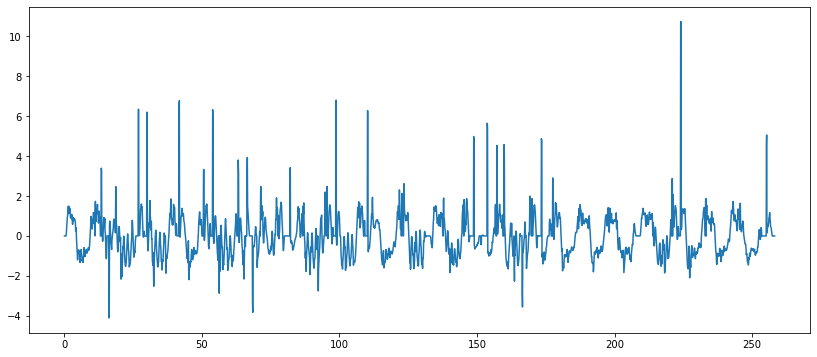

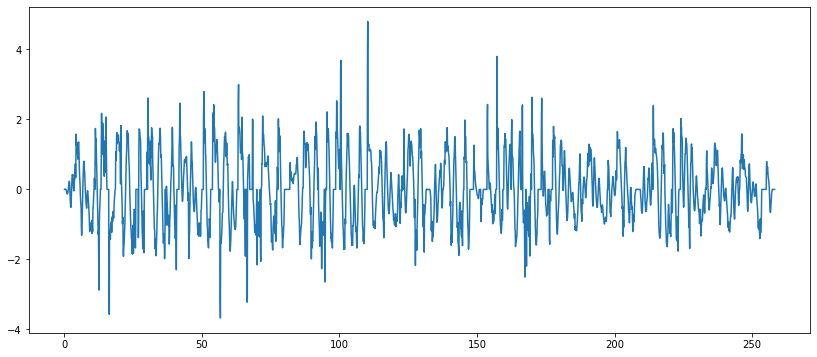

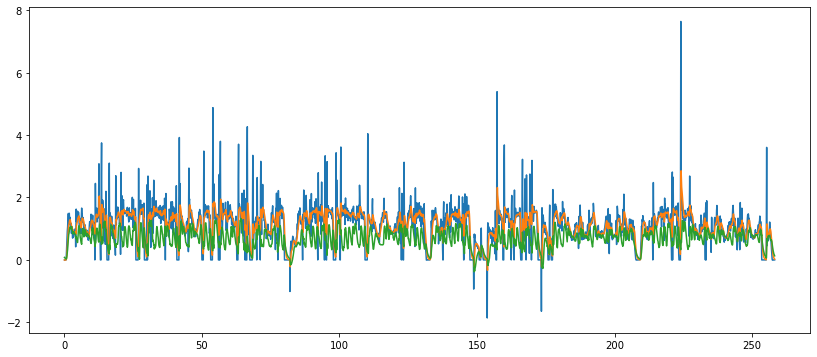

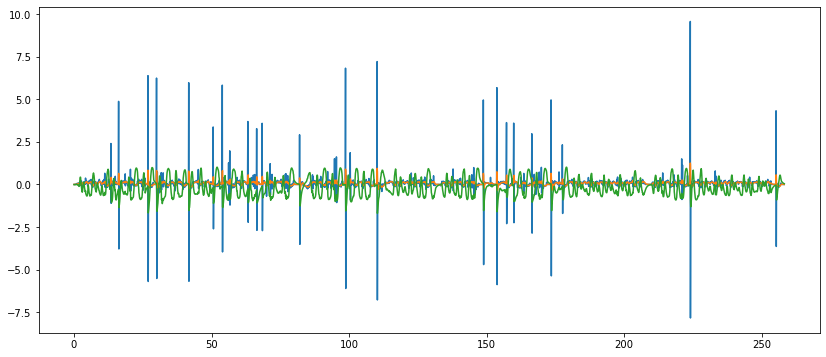

In [111]:
from numpy.fft import rfft, irfft, rfftfreq

def low_pass(s,cut_off_freq, time_step):
    fourier = rfft(s)
    f = rfftfreq(s.size, d=time_step)
    fourier = fourier * np.ones(len(f)) * cut_off_freq/(f + cut_off_freq)
    return irfft(fourier)

def discrete_lp(x, omega_c, T):
    
    N = len(x)
    y = np.zeros((N))
    y[0] = x[0]
    alpha = (2 - T * omega_c) / (2 + T * omega_c)
    beta = T * omega_c / (2 + T * omega_c)
    for k in range(1, N):
        y[k] = alpha * y[k - 1] + beta * (x[k] + x[k - 1])
    return y
    
    
    
        

vX_train = np.gradient(X_train, t_train)
vY_train = np.gradient(Y_train, t_train)

vx_prova_train = vX_train*np.cos(theta_train) + vY_train*np.sin(theta_train)
vy_prova_train = -vX_train*np.sin(theta_train) + vY_train*np.cos(theta_train)

vx_prova_train_old = vx_prova_train
vy_prova_train_old = vy_prova_train



## DELETE THE SPIKES
# idx_x = []
# for ii in range(1, len(vx_prova_train)):
#     if (abs(vx_prova_train[ii] - vx_prova_train[ii-1]) > 0.1):
# #         print(ii)
#         idx_x = [ *idx_x, ii]

# for k in idx_x:
    
#     if ( vx_prova_train[k] - vx_prova_train[k-1] ) > 0 :
#         vx_prova_train[k] = vx_prova_train[k-1] + 0.05
#     else :
#         vx_prova_train[k] = vx_prova_train[k-1] - 0.05
        
# idx_y = []
# for ii in range(1, len(vy_prova_train)):
#     if (abs(vy_prova_train[ii] - vy_prova_train[ii-1]) > 0.1):
# #         print(ii)
#         idx_y = [ *idx_y, ii]

# for k in idx_y:
    
#     if ( vy_prova_train[k] - vy_prova_train[k-1] ) > 0 :
#         vy_prova_train[k] = vy_prova_train[k-1] + 0.05
#     else :
#         vy_prova_train[k] = vy_prova_train[k-1] - 0.05
        


# discrete filter
vx_pre_train_raw = 0
vy_pre_train_raw = 0

vx_pre_train_lf = 0
vy_pre_train_lf = 0

t_pre = 0

f = 3

# vx_train_lf = low_pass(vx_prova_train, fx, time_step)
# vy_train_lf = low_pass(vy_prova_train, fy, time_step)

vx_train_lf = discrete_lp(vx_prova_train, f, time_step)
vy_train_lf = discrete_lp(vy_prova_train, f, time_step)


# vx_train_lf = np.zeros(vx_train.shape)
# vy_train_lf = np.zeros(vy_train.shape)

# for ii in range(1,vx_train.shape[0]):
    
#     T = t_train[ii] - t_pre
# #     print(T)
    
#     vx_train_lf[ii] = ( vx_train[ii]*fx*T + vx_pre_train_raw*fx*T - vx_pre_train_lf*(fx*T-2) )/ (fx*T + 2)
#     vy_train_lf[ii] = ( vy_train[ii]*fy*T + vy_pre_train_raw*fy*T - vy_pre_train_lf*(fy*T-2) )/ (fy*T + 2)
    
#     t_pre = t_train[ii]
    
#     vx_pre_train_raw = vx_train[ii]
#     vx_pre_train_lf = vx_train_lf[ii]  
#     vy_pre_train_raw = vy_train[ii]
#     vy_pre_train_lf = vy_train_lf[ii]
    
# for i in range(len(vx_train_lf)):
#     if vx_train_lf[i]<0:
#         vx_train_lf[i] = 0

plt.figure(figsize=(14,6))
plt.plot(t_train, vX_train)

plt.figure(figsize=(14,6))
plt.plot(t_train, vY_train)


plt.figure(figsize=(14,6))
plt.plot(t_train, vx_prova_train_old)
plt.plot(t_train, vx_train_lf)
plt.plot(t_train, vx_train)



plt.figure(figsize=(14,6))
plt.plot(t_train, vy_prova_train)
plt.plot(t_train, vy_train_lf)
plt.plot(t_train, vy_train)
# plt.ylim((-2,2))


(-2, 2)

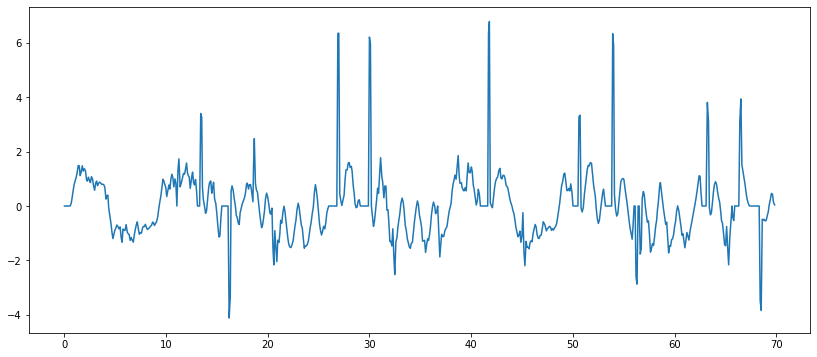

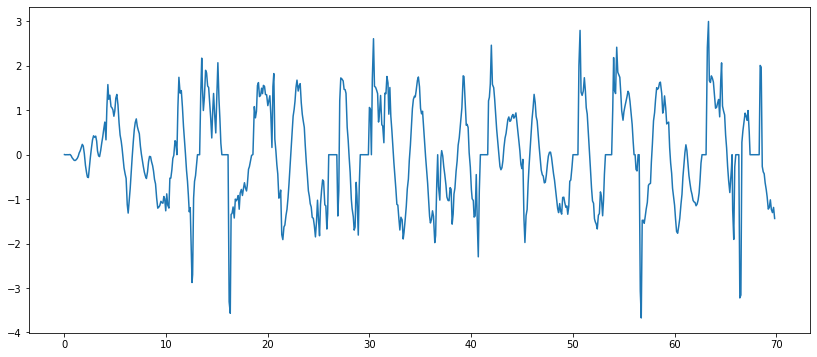

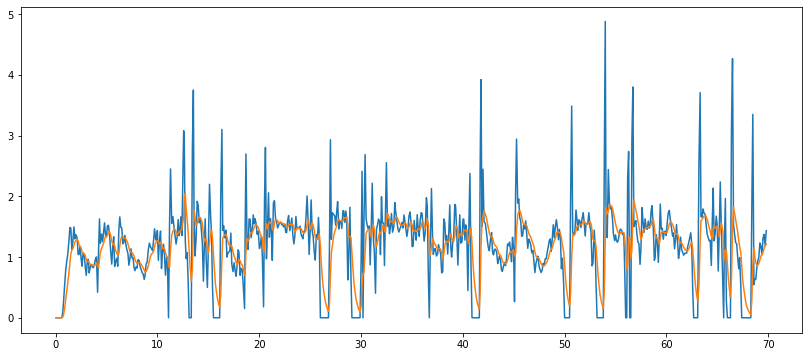

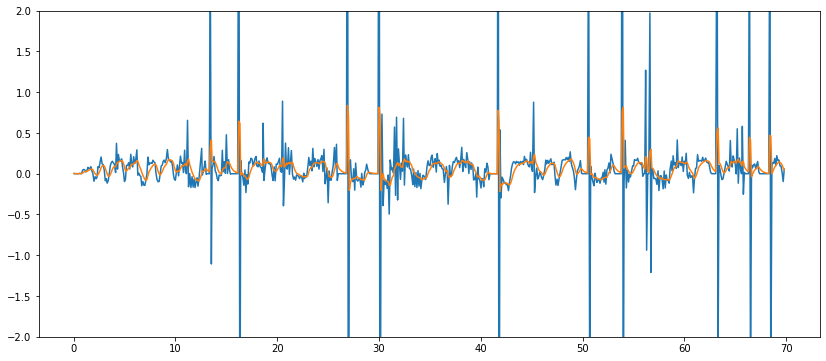

In [112]:
from numpy.fft import rfft, irfft, rfftfreq

def low_pass(s,cut_off_freq, time_step):
    fourier = rfft(s)
    f = rfftfreq(s.size, d=time_step)
    fourier = fourier * np.ones(len(f)) * cut_off_freq/(f + cut_off_freq)
    return irfft(fourier)

vX_test = np.gradient(X_test, t_test)
vY_test = np.gradient(Y_test, t_test)

vx_prova_test = vX_test*np.cos(theta_test) + vY_test*np.sin(theta_test)
vy_prova_test = -vX_test*np.sin(theta_test) + vY_test*np.cos(theta_test)

# discrete filter
vx_pre_test_raw = 0
vy_pre_test_raw = 0

vx_pre_test_lf = 0
vy_pre_test_lf = 0

t_pre = 0

# idx_x = []
# for ii in range(1, len(vx_prova_test)):
#     if (abs(vx_prova_test[ii] - vx_prova_test[ii-1]) > 0.1):
# #         print(ii)
#         idx_x = [ *idx_x, ii]

# for k in idx_x:
    
#     if ( vx_prova_test[k] - vx_prova_test[k-1] ) > 0 :
#         vx_prova_test[k] = vx_prova_test[k-1] + 0.05
#     else :
#         vx_prova_test[k] = vx_prova_test[k-1] - 0.05
        
# idx_y = []
# for ii in range(1, len(vy_prova_test)):
#     if (abs(vy_prova_test[ii] - vy_prova_test[ii-1]) > 0.1):
# #         print(ii)
#         idx_y = [ *idx_y, ii]

# for k in idx_y:
    
#     if ( vy_prova_test[k] - vy_prova_test[k-1] ) > 0 :
#         vy_prova_test[k] = vy_prova_test[k-1] + 0.05
#     else :
#         vy_prova_test[k] = vy_prova_test[k-1] - 0.05

# vx_test_lf = low_pass(vx_prova_test, fx, time_step)
# vy_test_lf = low_pass(vy_prova_test, fy, time_step)

vx_test_lf = discrete_lp(vx_prova_test, f, time_step)
vy_test_lf = discrete_lp(vy_prova_test, f, time_step)

# vx_train_lf = np.zeros(vx_train.shape)
# vy_train_lf = np.zeros(vy_train.shape)

# for ii in range(1,vx_train.shape[0]):
    
#     T = t_train[ii] - t_pre
# #     print(T)
    
#     vx_train_lf[ii] = ( vx_train[ii]*fx*T + vx_pre_train_raw*fx*T - vx_pre_train_lf*(fx*T-2) )/ (fx*T + 2)
#     vy_train_lf[ii] = ( vy_train[ii]*fy*T + vy_pre_train_raw*fy*T - vy_pre_train_lf*(fy*T-2) )/ (fy*T + 2)
    
#     t_pre = t_train[ii]
    
#     vx_pre_train_raw = vx_train[ii]
#     vx_pre_train_lf = vx_train_lf[ii]  
#     vy_pre_train_raw = vy_train[ii]
#     vy_pre_train_lf = vy_train_lf[ii]

for i in range(len(vx_test_lf)):
    if vx_test_lf[i]<0:
        vx_test_lf[i] = 0
    

plt.figure(figsize=(14,6))
plt.plot(t_test, vX_test)

plt.figure(figsize=(14,6))
plt.plot(t_test, vY_test)


plt.figure(figsize=(14,6))
plt.plot(t_test, vx_prova_test)
plt.plot(t_test, vx_test_lf)


plt.figure(figsize=(14,6))
plt.plot(t_test, vy_prova_test)
plt.plot(t_test, vy_test_lf)
plt.ylim((-2,2))


In [113]:
vx_train = vx_train_lf
vy_train = -vy_train_lf

vx_test = vx_test_lf
vy_test = -vy_test_lf


alpha_r = np.arctan2( ( lr*w_train - vy_train ), vx_train )
alpha_f = steer_train - np.arctan2( lr*w_train + vy_train, vx_train )



#    # SAVE DATA for matlab fitting

In [114]:
# data_1 = np.vstack((tau_train, steer_train, vx_train, vy_train, w_train, theta_train, w_train_opti))
# print(data_1.shape)
# mdic1 = {'data1' : data_1, 'label': 'filt_Opti'}
# data_2 = np.vstack((tau_test, steer_test, vx_test, vy_test, w_test, theta_test, w_test_opti))
# print(data_2.shape)
# mdic2 = {'data1' : data_2, 'label': 'filt_Opti'}

# scipy.io.savemat('matlab_data1_LUNGO.mat', mdic1)
# scipy.io.savemat('matlab_data2_HIGH.mat', mdic2)

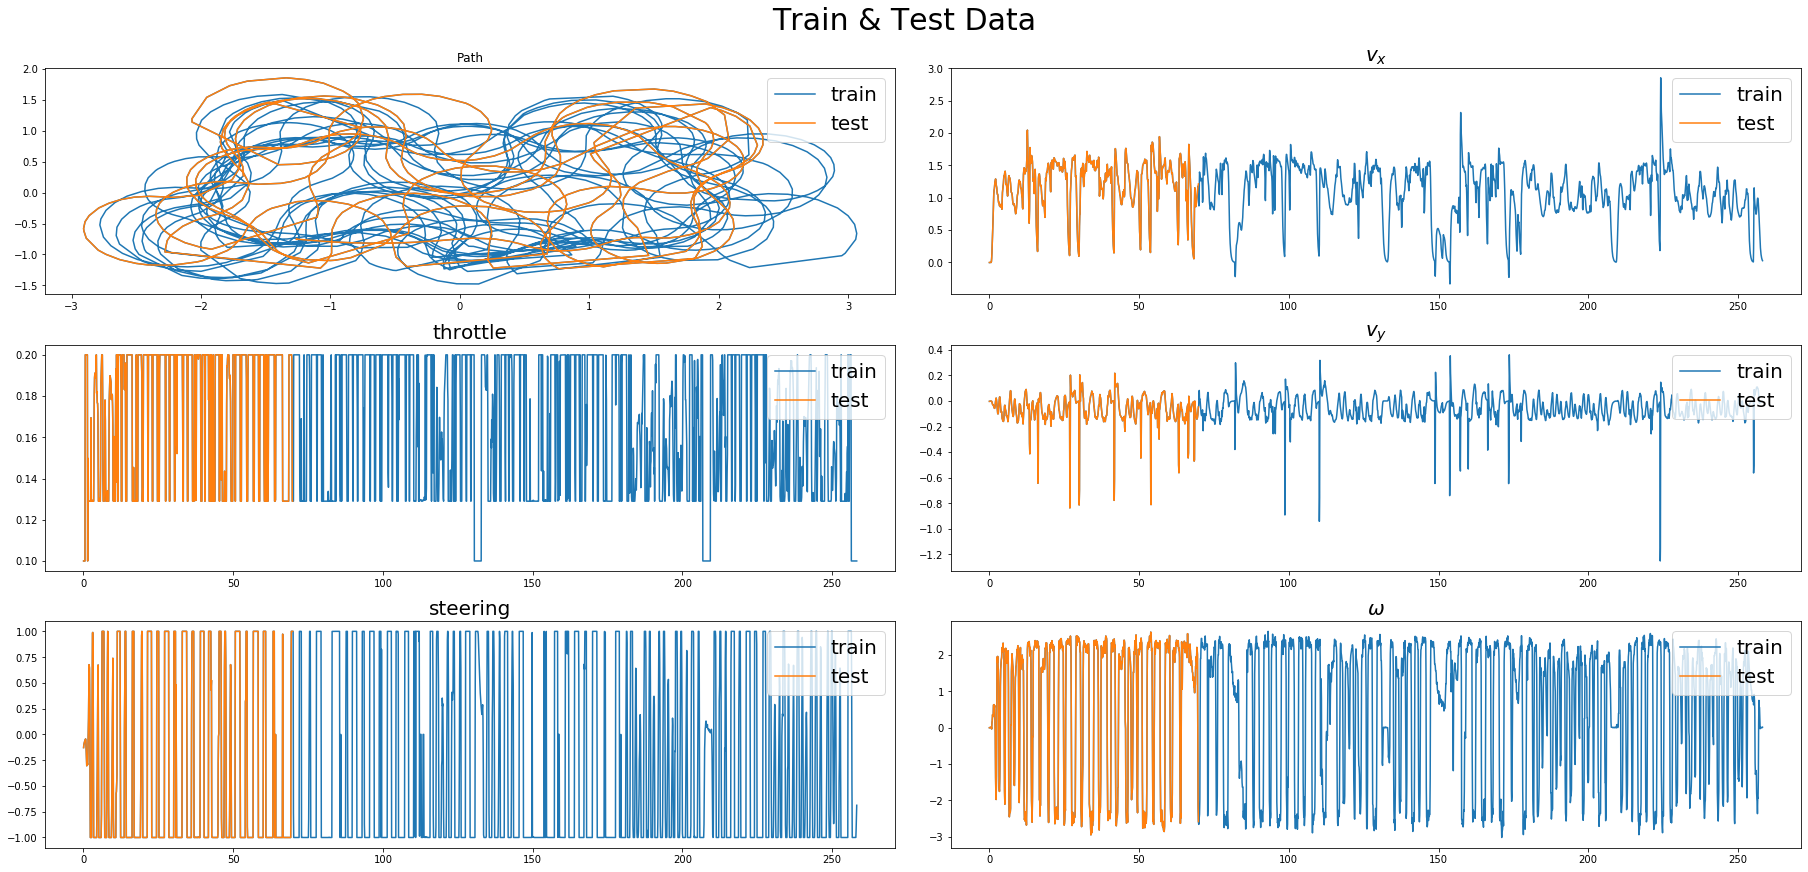

In [115]:
fig, ( (ax1, ax2), (ax3, ax4), (ax5, ax6) ) = plt.subplots(3, 2, figsize=(25, 12), constrained_layout=True)
fig.suptitle('Train & Test Data', fontsize=30)

ax1.set_title('Path')
ax1.plot(X_train, Y_train, label='train')
ax1.plot(X_test, Y_test, label='test')
ax1.legend(loc='upper right', fontsize=20)


# TAU
ax3.plot(t_train, tau_train, label='train')
ax3.plot(t_test, tau_test, label='test')
# plt.plot(t_train, data_numpy_train[:,5])
ax3.set_title('throttle', fontsize=20)
ax3.legend(loc='upper right', fontsize=20)

# STEER
ax5.plot(t_train, data_numpy_train[:,6], label='train')
ax5.plot(t_test, data_numpy_test[:,6], label='test')
ax5.set_title('steering', fontsize=20)
ax5.legend(loc='upper right', fontsize=20)

# LOCAL SPEED vx
ax2.plot(t_train, vx_train, label='train')
ax2.plot(t_test, vx_test, label='test')
# plt.plot(data_numpy_train[:,9], vx_train_lf)
ax2.set_title('$v_x$', fontsize=20)
ax2.legend(loc='upper right', fontsize=20)

# LOCAL SPEED vy
ax4.plot(t_train, vy_train, label='train')
ax4.plot(t_test, vy_test, label='test')
# plt.plot(data_numpy_train[:,9], vy_train_lf)
ax4.set_title('$v_y$', fontsize=20)
ax4.legend(loc='upper right', fontsize=20)
# plt.ylim((-1,1))

# OMEGA
ax6.plot(t_train, w_train, label='train')
ax6.plot(t_test, w_test, label='test')
# plt.plot(t_train, w_train_opti)
ax6.set_title('$\\omega$', fontsize=20)
ax6.legend(loc='upper right', fontsize=20)

plt.savefig('pictures_4_thesis/sim/Train&Test_dataset.png',dpi=300)

# # TAU
# plt.figure(figsize=(15,6))
# plt.plot(t_test, tau_test)
# # plt.plot(t_train, data_numpy_train[:,5])
# plt.title('$\\tau$')

# # STEER
# plt.figure(figsize=(15,6))
# plt.plot(t_test, data_numpy_test[:,6])
# plt.title('steer')

# # LOCAL SPEED vx
# plt.figure(figsize=(15,6))
# plt.plot(t_test, vx_test)
# # plt.plot(data_numpy_train[:,9], vx_train_lf)
# plt.title('LOCAL SPEED Vx')

# # LOCAL SPEED vy
# plt.figure(figsize=(15,6))
# plt.plot(t_test, vy_test)
# # plt.plot(data_numpy_train[:,9], vy_train_lf)
# plt.title('LOCAL SPEED Vy')
# # plt.ylim((-1,1))

# # OMEGA
# plt.figure(figsize=(15,6))
# plt.plot(t_test, w_test)
# # plt.plot(t_train, w_train_opti)
# plt.title('$\\omega$')

# Overwrite raw data with filtered data

In [116]:
data_train = np.zeros((N_train,10))
data_train[:,0] = safety_train
data_train[:,1] = tau_train
data_train[:,2] = steer_train
data_train[:,3] = np.zeros(N_train)
data_train[:,4] = np.zeros(N_train)
data_train[:,5] = vx_train
data_train[:,6] = vy_train
data_train[:,7] = w_train
data_train[:,8] = tau_pre_train
data_train[:,9] = steer_pre_train

data_test = np.zeros((N_test,10))
data_test[:,0] = safety_test
data_test[:,1] = tau_test
data_test[:,2] = steer_test
data_test[:,3] = np.zeros(N_test)
data_test[:,4] = np.zeros(N_test)
data_test[:,5] = vx_test
data_test[:,6] = vy_test
data_test[:,7] = w_test
data_test[:,8] = tau_pre_test
data_test[:,9] = steer_pre_test

#              0       1      2    3     4     5    6    7      8     9       10       11        12
#           safety throttle steer curr volt   vx   vy    w    v_enc  time   x_opti   y_opti  theta_opti

# Define the nominal dynamics

In [117]:
# def nominal_dynamics( throttle, delta_cmd, v_x, v_y, w):
    
#     L = 0.175
#     m = 1.63
#     Iz = 0.0061
#     lr = 0.45*L
#     lf = L - lr
#     dt = 0.1
    
#     coeff = np.array([0.581473025742521,0.650802766746955,4.783086518915680,1.070107533337737] )
#     coeff = np.array([1.015257820367660,1.470271822429169,10.216527063832183,1.660350634138415] )
    
#     Df = coeff[0]
#     Dr = coeff[1]
       
#     a_mot = coeff[2]
#     b_mot = coeff[3]


# #     delta = 0.3389*np.arctan2(1.461*delta_cmd,1)
#     delta = delta_cmd
    
#     alpha_f = delta - np.arctan2( v_y + lf*w, v_x )
#     alpha_r = np.arctan2( -v_y + lr*w, v_x )
    
#     Fx = ( a_mot*throttle - b_mot*v_x ) * m
#     Ff = Df*alpha_f
#     Fr = Dr*alpha_r
        
#     acc_x = 1/m * ( Fx/2 + Fx/2*np.cos(delta) - Ff*np.sin(delta) + m*v_y*w )

#     acc_y = 1/m * ( Fx/2*np.sin(delta) + Fr + Ff*np.cos(delta) - m*v_x*w )
    
#     w_dot = 1/Iz * ( lf * ( Fx/2*np.sin(delta) + Ff*np.cos(delta) ) - Fr*lr)
    
#     v_x_next = v_x + dt * acc_x
#     v_y_next = v_y + dt * acc_y
#     w_next = w + dt * w_dot
    
#     f_nom = torch.tensor([ [ v_x_next, v_y_next, w_next ] ])
    
#     return f_nom

In [118]:
def nominal_dynamics( throttle, delta_cmd, v_x, v_y, w):
    
    L = 0.175
    m = 1.63
    Iz = 0.0061
    lr = 0.45*L
    lf = L - lr
    dt = 0.1
    
    # Joystick
#     coeff = np.array([ 0.693269796073301,1.95806694464934,1.92085952988382,0.686447602670706,0.769561720505785,1.05964496201507,33.6975812374592,1.09360535677470,4.30726112026115])
    
    # LOW SPEED 
    coeff = np.array([0.464057573497732, 3.456346397163573, 19.451653912004943, 0.173236915980059, 0.079416030663782,1.328088550698735, 4.890646929001010, 1.091612670338737, 9.940588122706625*10**(-8)])
    
    # HIGH SPEED
#     coeff = np.array([0.679115033132576, 1.193406751450747, 1.207698614596029, 5.811380339145567, 1.383597852169577, 0.263095423084969, 6.918962475385593, 1.241782612109949, 5.697407191996113*10**(-4)])

    # MEDIUM SPEED long batch
    coeff = np.array([55.619546090802665,2.455122820164469,0.010656085085740,10.390787245737815,2.372514246591150,0.050831207731079,11.244777487512259,1.821951728405532,6.889277937871838*10**(-4)])
    
    # combined low and high speed
#     coeff = np.array([3.762547440173825,19.850903350428045,0.085178464984133,0.473955929897818,3.553983069859954,0.105797167956186,4.824887542832687,0.984257648333988,0.043591272748673])
  
    # coeff tenendo conto che quando la safety è disengaged tau=0.1
#     coeff = np.array([0.752685355472361,1.540305379448891,1.058616091954596,1.940921705313646,2.304472610461974,0.541416010858391,13.273186291933333,2.114794669370659,1.055449681457805*10**(-4)])
    
    # new set of parameters with nice tyre forces
#     coeff = np.array([0.752685355472361,1.540305379448891,1.058616091954596,1.940921705313646,2.304472610461974,0.541416010858391,13.273186291933333,2.114794669370659,1.0554496814578*10**(-4)])

    coeff = np.array([80.572170382723900,2.542905105634004,0.159874374537897,11.123033969725284,0.133774546845049,0.062454679156792,17.414433429457933,0.361806792259144,2.003778186866944])
    
    coeff = [0.767293975606969,7.762394594884883,1.230205546590822,0.524549326671976,0.835571105086099,0.223312582394467,15.744478651869810,6.572073314691472]
    
    
    Df = coeff[0]
    Dr = coeff[1]
    Cf = coeff[2]
    Cr = coeff[3]
    Bf = coeff[4]
    Br = coeff[5]
        
    a_mot = coeff[6]
    b_mot = coeff[7]
    c_mot = a_mot*0.1

#     delta = 0.3389*np.arctan2(1.461*delta_cmd,1)
    delta = delta_cmd
    
    alpha_f = delta - np.arctan2( v_y + lf*w, v_x )
    alpha_r = np.arctan2( -v_y + lr*w, v_x )
    
    Fx = ( (a_mot - b_mot*v_x)*throttle - c_mot ) * m
    Ff = Df*np.sin(Cf*np.arctan2(Bf*alpha_f,1))
    Fr = Dr*np.sin(Cr*np.arctan2(Br*alpha_r,1))
        
    acc_x = 1/m * ( Fx/2 + Fx/2*np.cos(delta) - Ff*np.sin(delta) + m*v_y*w )

    acc_y = 1/m * ( Fx/2*np.sin(delta) + Fr + Ff*np.cos(delta) - m*v_x*w )
    
    w_dot = 1/Iz * ( lf * ( Fx/2*np.sin(delta) + Ff*np.cos(delta) ) - Fr*lr)
    
    v_x_next = v_x + dt * acc_x
    v_y_next = v_y + dt * acc_y
    w_next = w + dt * w_dot
    
    f_nom = torch.tensor([ [ v_x_next, v_y_next, w_next ] ])
    
    return f_nom

# Convert data to tensors

In [119]:
#              0       1      2    3     4     5    6    7      8     9       10       11        12
#           safety throttle steer curr volt   vx   vy    w    v_enc  time   x_opti   y_opti  theta_opti
# train_inputs_indexes = [ 1, 2, 5, 6, 7, 8, 9 ]
train_inputs_indexes = [ 1, 2, 5, 6, 7 ]
train_outputs_indexes = [ 5, 6, 7 ]

train_x = torch.tensor(data_train[:-1, train_inputs_indexes])  #cuda moves it to the GPU
x_next_train = torch.tensor(data_train[1:, train_outputs_indexes])

test_x = torch.tensor(data_test[:-1, train_inputs_indexes])
x_next_test = torch.tensor(data_test[1:, train_outputs_indexes])


In [120]:
vx_train[1]

-0.0031940153774698277

In [121]:
train_x[1,2]

tensor(-0.0032, dtype=torch.float64)

# Write train_y

In [122]:
#             0      1      2      3     4               
#         throttle steer   vx     vy     w   

f_nom_matrix = torch.zeros(1,3) # initialize a row vector of zeros
N = len(train_x)
t_train = np.linspace(dt, N*time_step, N)

for ii in range(0,N):
    
    f_nom = nominal_dynamics(train_x[ii,0], train_x[ii,1], train_x[ii,2], train_x[ii,3], train_x[ii,4])
    f_nom_matrix = torch.cat((f_nom_matrix,f_nom), dim=0)
       
f_nom_matrix = f_nom_matrix[1:,:]

train_y = x_next_train - f_nom_matrix


In [123]:
f_nom_matrix[2,:]

tensor([-0.0037,  0.1683, -1.3989], dtype=torch.float64)

Text(0.5, 1.0, '$\\omega$ ')

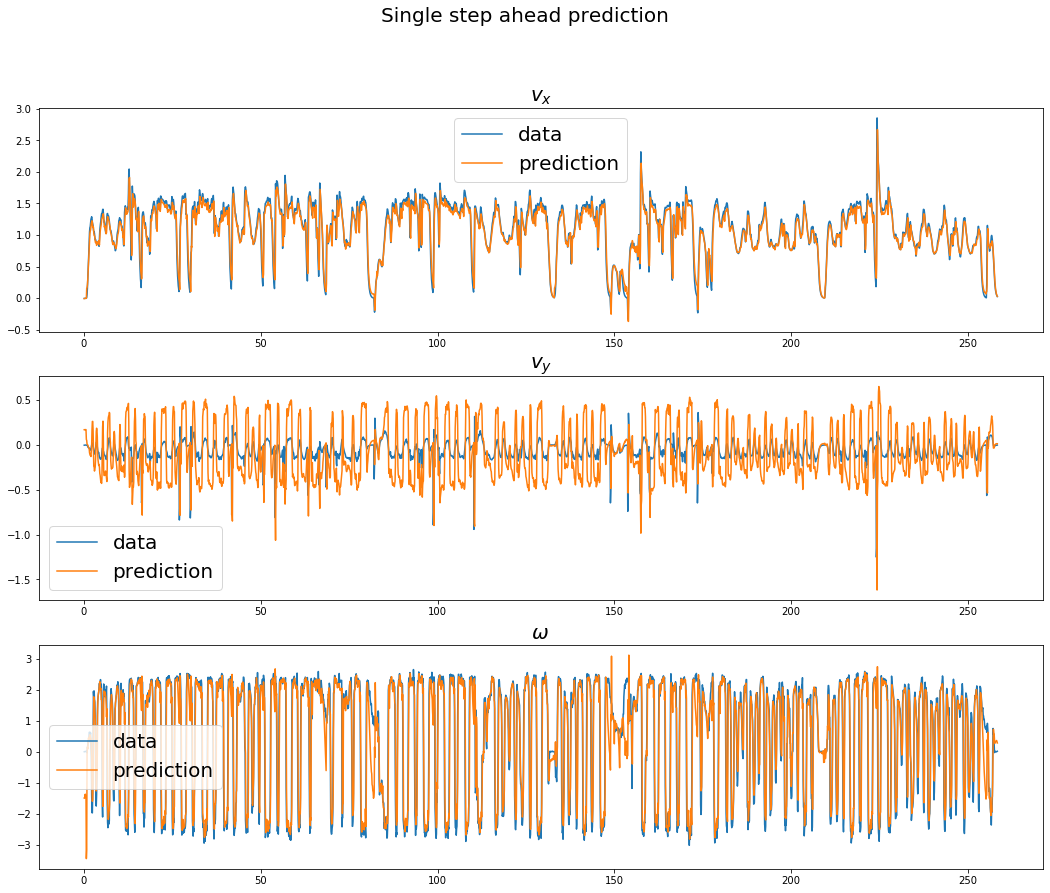

In [124]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18,14))
f.suptitle('Single step ahead prediction', fontsize=20)
    
ax1.plot(t_train[:], vx_train[1:], label='data' )
ax1.plot(t_train[:], f_nom_matrix[:,0], label='prediction')
ax1.legend(fontsize=20)
ax1.set_title('$v_x$', fontsize=20)
    
ax2.plot(t_train[:], vy_train[1:], label='data' )
ax2.plot(t_train[:], f_nom_matrix[:,1], label='prediction') 
ax2.legend(fontsize=20)
ax2.set_title('$v_y$', fontsize=20)
    
ax3.plot(t_train[:], w_train[1:], label='data')
ax3.plot(t_train[:], f_nom_matrix[:,2], label='prediction')
ax3.legend(fontsize=20)
ax3.set_title('$\\omega$ ', fontsize=20)

In [125]:
f_nom_matrix = torch.zeros(1,3) # initialize a row vector of zeros
N_test = len(test_x)
t_test = np.linspace(dt, N_test*time_step, N_test)

for ii in range(0,N_test):
    
    f_nom = nominal_dynamics(test_x[ii,0], test_x[ii,1], test_x[ii,2], test_x[ii,3], test_x[ii,4])
    f_nom_matrix = torch.cat((f_nom_matrix,f_nom), dim=0)
       
f_nom_matrix = f_nom_matrix[1:,:]

f_nom_matrix

test_y = x_next_test - f_nom_matrix

Text(0.5, 1.0, '$\\omega$ ')

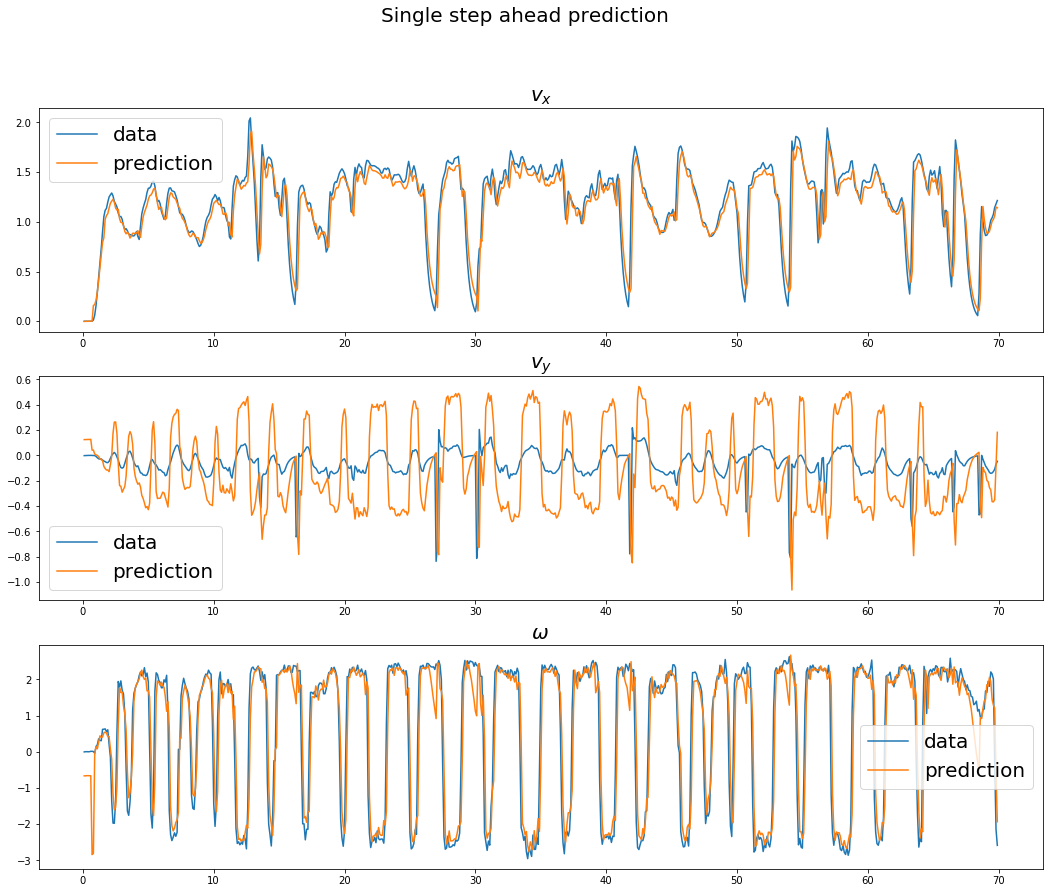

In [126]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18,14))
f.suptitle('Single step ahead prediction', fontsize=20)
    
ax1.plot(t_test[:], vx_test[1:], label='data' )
ax1.plot(t_test[:], f_nom_matrix[:,0], label='prediction')
ax1.legend(fontsize=20)
ax1.set_title('$v_x$', fontsize=20)
    
ax2.plot(t_test, vy_test[1:], label='data' )
ax2.plot(t_test, f_nom_matrix[:,1], label='prediction') 
ax2.legend(fontsize=20)
ax2.set_title('$v_y$', fontsize=20)
    
ax3.plot(t_test, w_test[1:], label='data')
ax3.plot(t_test, f_nom_matrix[:,2], label='prediction')
ax3.legend(fontsize=20)
ax3.set_title('$\\omega$ ', fontsize=20)

# Define the SVGP model

In [127]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
from torch.utils.data import TensorDataset, DataLoader

In [128]:
check = train_x[::int(train_y.shape[-2]/200),:]
# check = train_x[:100,:]
print(check.shape)
print(train_x.shape)

torch.Size([216, 5])
torch.Size([2583, 5])


In [129]:
# if torch.cuda.is_available():
#     train_x, train_y, test_x = train_x.cuda(), train_y.cuda(), test_x.cuda()
    

In [130]:
class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ZeroMean()
#         self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=inducing_points.shape[-1]))
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=inducing_points.shape[-1]))
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


class SparseGPy:
    def __init__(self, train_x, train_y, test_x, batch_size, num_epochs):
        self.train_x = train_x
        self.train_y = train_y
        self.test_x = test_x
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.likelihood = []
        self.model = []
        
    def train(self):
        for ii in range(self.train_y.shape[-1]):
            train_dataset = TensorDataset(self.train_x, self.train_y[:,ii])
            train_loader = DataLoader(train_dataset, batch_size = self.batch_size, shuffle=True)
#             inducing_points = self.train_x[::int(self.train_y.shape[-2]/200),:]
            inducing_points = self.train_x[:50,:]
            model = GPModel(inducing_points=inducing_points)
            model = model.double()
            model = model
            likelihood = gpytorch.likelihoods.GaussianLikelihood()
            likelihood = likelihood
            model.train()
            likelihood.train()
            optimizer = torch.optim.Adam([
                {'params': model.parameters()},
                {'params': likelihood.parameters()},
                ], lr=0.1)
            mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=self.train_y[:,ii].size(0))
            num_epochs = self.num_epochs
            epochs_iter = tqdm(range(num_epochs), desc="Epoch")
            for i in epochs_iter:
                # Within each iteration, we will go over each minibatch of data
                minibatch_iter = tqdm(train_loader, desc='Minibatch', leave=False)
                for x_batch, y_batch in minibatch_iter:
                    optimizer.zero_grad()
                    output = likelihood(model(x_batch))
                    loss = -mll(output, y_batch)
                    minibatch_iter.set_postfix(loss=loss.item())
                    loss.backward()
                    optimizer.step()
            self.likelihood.append(likelihood)
            self.model.append(model) 
    
    def prediction(self):
        self.mean = np.empty([self.test_x.shape[0],self.train_y.shape[1]])
        self.upper = np.empty([self.test_x.shape[0],self.train_y.shape[1]])
        self.lower = np.empty([self.test_x.shape[0],self.train_y.shape[1]])
        self.pred_dist = []
        
        for ii in range(self.train_y.shape[-1]):
            self.model[ii].eval()
            self.likelihood[ii].eval()
            observed_pred = self.likelihood[ii](self.model[ii](self.test_x))
            self.pred_dist.append(observed_pred)
            self.mean[:,ii] = observed_pred.mean.detach()
            lower, upper = observed_pred.confidence_region()
            self.upper[:,ii] = lower.detach()
            self.lower[:,ii] = upper.detach()

    def get_kernel_params(self):
        self.sigma_f = []
        self.length_scale = []
        self.variance = []
        self.sigma_n = []
        for ii in range(self.train_y.shape[-1]):
            self.sigma_f.append(self.model[ii].covar_module.outputscale.item())
            self.sigma_n.append(self.likelihood[ii].noise_covar.noise.item())
    
            for jj in range(0,self.train_x.shape[-1]):
                self.length_scale.append(self.model[ii].covar_module.base_kernel.lengthscale.detach().numpy().item(jj))

        self.length_scale = np.reshape(np.ravel(self.length_scale), (self.train_y.shape[-1],self.train_x.shape[-1]) )
#     def save_kernel_params(self):
#         for ii in range(self.train_y.shape[-1]):
            
    
    def save_model(self):
        for ii in range(self.train_y.shape[-1]):
            torch.save(self.model[ii].state_dict(), 'model_state_' + str(ii+1) + '.pth')


        

In [131]:
sparse_GP = SparseGPy(train_x, train_y, test_x, 1000, 100) # batch/ epochs ancora da ragionarci

In [132]:
tic = time.time()
sparse_GP.train()
toc = time.time()
print(toc-tic)

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/3 [00:00<?, ?it/s]

58.61277198791504


In [133]:
sparse_GP.prediction()

In [134]:
sparse_GP.get_kernel_params()

In [135]:



def produce_K_xy_Zero_mean_RBF(x, y, outputscale, lengthscales):

    length_mat = np.diag(lengthscales)
    lengths_pow_minus_2 = np.linalg.inv(np.matmul(length_mat, length_mat))

    # it will come out like [nx ny] where x = [nx, M] y = [ny, M], M features
    size_x = len(x[:, 0])
    size_y = len(y[:, 0])
    Kxy = np.zeros([size_x, size_y])


    for i in range(size_x):
        xi = x[i, :]
        for j in range(size_y):
            xj = y[j, :]
            Kxy[i, j] = outputscale * np.exp(-0.5 * (np.matmul(np.matmul(np.transpose(xi - xj), lengths_pow_minus_2), xi - xj)))

    return Kxy

In [136]:
def produce_K_xstar_X_Zero_mean_RBF(x_star, x_data, outputscale, lengthscales):

    n_data = x_data.shape[0]  # cause really we will use this with only 1 data point where to evaluate the GP
    m_features = x_data.shape[1]


    lengths_pow_minus_2 = np.zeros(m_features)
    for i in range(m_features):
        lengths_pow_minus_2[i] = 1 / (lengthscales[i] * lengthscales[i])

    # it will come out like [nx ny] where x = [nx, M] y = [ny, M], M features
    #hard coded features and data points

    #Kxy = np.zeros([size_x, size_y])
    K_xstar_X = np.zeros(n_data)

    # re-writing to avoid any over-writing of variables
    """
        for j in range(n_data):
            xj = x_data[j, :]
            #this for loop is only to avoid matrix multiplication in casadi (maybe it's not necessary)
            exp_arg = casadi.SX.zeros(1, 1)
            for k in range(m_features):
                exp_arg = exp_arg + (x_star[k]-xj[k]) * (x_star[k]-xj[k]) * lengths_pow_minus_2[k]
    
            K_xstar_X[j] = outputscale * casadi.exp(-0.5 * exp_arg)
    """
    for j in range(n_data):
        xj = x_data[j, :]
        # this for loop is only to avoid matrix multiplication in casadi (maybe it's not necessary)
        #exp_arg = casadi.SX.zeros(1, m_features)
        #for k in range(m_features):
        #    exp_arg[k] = ((x_star[k] - xj[k]) * (x_star[k] - xj[k]) * lengths_pow_minus_2[k])
        # this is really really hard coded to avoid any chance of weird behaviour
        K_xstar_X[j] = outputscale * np.exp(-0.5 * (((x_star[0] - xj[0]) * (x_star[0] - xj[0]) * lengths_pow_minus_2[0])+
                                                        ((x_star[1] - xj[1]) * (x_star[1] - xj[1]) * lengths_pow_minus_2[1])+
                                                        ((x_star[2] - xj[2]) * (x_star[2] - xj[2]) * lengths_pow_minus_2[2])+
                                                        ((x_star[3] - xj[3]) * (x_star[3] - xj[3]) * lengths_pow_minus_2[3])+
                                                        ((x_star[4] - xj[4]) * (x_star[4] - xj[4]) * lengths_pow_minus_2[4])))


    return K_xstar_X


In [137]:
print("Noise variance: " , sparse_GP.sigma_n)
# print(f'Noise variance: {item: .2f}' for item in sparse_GP.sigma_n)
print("Lengthscale: ", sparse_GP.length_scale)
print("Outputscale: ", sparse_GP.sigma_f)

Noise variance:  [0.006997067481279373, 0.005052577238529921, 0.2684761583805084]
Lengthscale:  [[1.76375253 3.22258333 1.64730368 0.31858962 6.83984125]
 [3.98324658 2.30041325 1.85414691 0.50217219 5.39766972]
 [3.67632301 0.41590231 0.81166744 0.37722433 1.51841997]]
Outputscale:  [0.08048106232315864, 0.1370326760166113, 0.36202145359032767]


In [138]:
# from linear_operator import to_dense
# from linear_operator.operators import (
#     CholLinearOperator,
#     DiagLinearOperator,
#     MatmulLinearOperator,
#     RootLinearOperator,
#     SumLinearOperator,
#     TriangularLinearOperator,
# )

In [139]:
# from linear_operator.utils.cholesky import psd_safe_cholesky
# from linear_operator.utils.errors import NotPSDError

In [140]:
dic0 = sparse_GP.model[0].state_dict()
dim_IPs = dic0['variational_strategy.inducing_points'].shape
IPs = dic0['variational_strategy.inducing_points']
covar = dic0['variational_strategy._variational_distribution.chol_variational_covar']
u = dic0['variational_strategy._variational_distribution.variational_mean']

# # jitter_val = 1**-3
# var_cov_root = TriangularLinearOperator(covar)
# var_cov = CholLinearOperator(var_cov_root)
# var_mean = dic0['variational_strategy._variational_distribution.variational_mean']

# if var_mean.shape[-1] != 1:
#     var_mean = var_mean.unsqueeze(-1)
    
# cov_diff = var_cov.add_jitter(-1.0)
# cov_diff = -1.0 * cov_diff
# print(cov_diff)

# Kmm = sparse_GP.model[0].covar_module(IPs)

# Kmm_root = Kmm.cholesky()

# eval_var_cov = var_cov.to_dense()
# print(eval_var_cov)

# eval_rhs = cov_diff.transpose(-1,-2).matmul(eval_var_cov)
# inner_term = cov_diff.matmul(cov_diff.transpose(-1, -2))
# # TODO: flag the jitter here
# inner_solve = inner_term.add_jitter(jitter_val).solve(eval_rhs, eval_var_cov.transpose(-1, -2))
# inducing_covar = var_cov + inner_solve

# inducing_covar = Kmm_root.matmul(inducing_covar).matmul(Kmm_root.transpose(-1, -2))


In [141]:
# def forward(self, x, inducing_points, inducing_values, variational_inducing_covar=None, **kwargs):
#     # Compute full prior distribution
#     full_inputs = torch.cat([inducing_points, x], dim=-2)
#     full_output = self.model.forward(full_inputs, **kwargs)
#     full_covar = full_output.lazy_covariance_matrix

#     # Covariance terms
#     num_induc = inducing_points.size(-2)
#     test_mean = full_output.mean[..., num_induc:]
#     induc_induc_covar = full_covar[..., :num_induc, :num_induc].add_jitter(self.jitter_val)
#     induc_data_covar = full_covar[..., :num_induc, num_induc:].to_dense()
#     data_data_covar = full_covar[..., num_induc:, num_induc:]

#     # Compute interpolation terms
#     # K_ZZ^{-1/2} K_ZX
#     # K_ZZ^{-1/2} \mu_Z
#     L = self._cholesky_factor(induc_induc_covar)
#     if L.shape != induc_induc_covar.shape:
#          # Aggressive caching can cause nasty shape incompatibilies when evaluating with different batch shapes
#         # TODO: Use a hook fo this
#         try:
#             pop_from_cache_ignore_args(self, "cholesky_factor")
#         except CachingError:
#             pass
#         L = self._cholesky_factor(induc_induc_covar)
#     interp_term = L.solve(induc_data_covar.type(_linalg_dtype_cholesky.value())).to(full_inputs.dtype)
#     # Compute the mean of q(f)
#     # k_XZ K_ZZ^{-1/2} (m - K_ZZ^{-1/2} \mu_Z) + \mu_X
#     predictive_mean = (interp_term.transpose(-1, -2) @ inducing_values.unsqueeze(-1)).squeeze(-1) + test_mean
    
#     return predictive_mean

In [142]:
# print(covar)
# print(np.matmul(covar, covar.H))

In [143]:
# # print(covar)
# # print(covar.H)
# # print(np.matmul(covar, covar.H)/sparse_GP.sigma_f[0])
# sigma_n = sparse_GP.sigma_n[0]
# out = sparse_GP.sigma_f[0]
# len_scale = sparse_GP.length_scale[0,:]
# print(len_scale)
# # K_zz = np.matmul(covar, np.transpose(covar))
# K_zz = produce_K_xy_Zero_mean_RBF(IPs, IPs, out, len_scale)
# K_zz_inv = np.linalg.inv(K_zz + sigma_n*np.identity(IPs.shape[0]) )
# right_block = np.matmul(K_zz_inv, u)

# point_test = test_x[0,:].detach().numpy()

# K_xz = produce_K_xstar_X_Zero_mean_RBF(point_test, IPs, out, len_scale)

# pred0 = np.matmul(K_xz, right_block)

# print(pred0)

# # print(mean.shape)
# print(K_zz)
# Kmm = sparse_GP.model[0].covar_module(IPs)
# print(Kmm.to_dense())



In [144]:
# point_test = test_x[1,:].detach().numpy()

# sigma_n = sparse_GP.sigma_n[0]
# out = sparse_GP.sigma_f[0]
# len_scale = sparse_GP.length_scale[0,:]

# K_xu = produce_K_xstar_X_Zero_mean_RBF(point_test, IPs, out, len_scale)
# print(K_xu.shape)
# K_uu = produce_K_xy_Zero_mean_RBF(IPs, IPs, out, len_scale)

# lamb =  sigma_n*np.identity(train_x.shape[0])
# inv_lamb = np.linalg.inv(lamb)

# K_uf = produce_K_xy_Zero_mean_RBF(IPs, train_x.detach().numpy(), out, len_scale)
# # K_fu = produce_K_xy_Zero_mean_RBF(train_x.detach().numpy(), IPs, out, len_scale)

# sigma = np.linalg.inv(K_uu + np.matmul(K_uf, np.matmul(inv_lamb, np.transpose(K_uf)) ) )
# print(K_uf.shape)

# rhs = np.matmul(inv_lamb, train_y[:,0])
# interm = np.matmul(K_xu, np.matmul(sigma, K_uf) )

# exp_mean = np.matmul(interm, rhs)
# print(exp_mean)

In [145]:
# inner = np.matmul(sigma, K_uf) 

# right_vec_block_Delta_vx = np.matmul(inner, rhs)
print(sparse_GP.mean[0:5,0])

[-0.02681585 -0.02670599 -0.02657967 -0.02637415 -0.02618523]


In [146]:
# print(IPs)
# print(np.matmul(covar, np.transpose(covar)))

In [147]:
sparse_GP.likelihood[0].noise_covar.noise.item()

0.006997067481279373

In [148]:
dim_IPs

torch.Size([50, 5])

In [149]:
sparse_GP.likelihood[0].noise_covar.noise.cpu().detach().numpy()

array([0.00699707], dtype=float32)

In [150]:
# sparse_GP.save_model()

In [151]:
# state_dict1 = torch.load('model_state_1.pth')

In [152]:
# state_dict1

In [153]:
# inducing_points = train_x[::int(train_y.shape[-2]/200),:]
# model = GPModel(inducing_points=inducing_points)
# model.load_state_dict(state_dict1)

In [154]:
# model.state_dict()
# # con_out = state_dict1['covar_module.raw_outputscale_constraint.upper_bound']
# con_out = model.covar_module.raw_outputscale_constraint
# print(con_out)
# rawscale = state_dict1['covar_module.raw_outputscale']
# outscale = con_out.transform(rawscale)
# print(outscale)

In [155]:
# print(sparse_GP.pred_dist[0].mean)
# print(sparse_GP.mean[:,0].shape)

In [156]:
test_x[0,:]

tensor([ 0.1000,  0.0420,  0.0000, -0.0026, -0.0026], dtype=torch.float64)

In [157]:
print(sparse_GP.mean[0:5,0])

[-0.02681585 -0.02670599 -0.02657967 -0.02637415 -0.02618523]


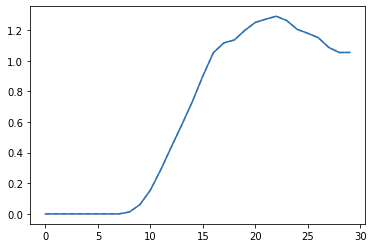

In [158]:
plt.plot(test_x[:30,2],'--', color='orchid', label='data')
plt.plot(vx_test[:30])

# SAVE the MODEL

In [159]:
path_to_data = '/home/riccardo/THESIS_CODE/Saved_models_and_data_sim_Riccardo_model/'
train_y_Delta_vx = train_y[:,0]
train_y_Delta_vy = train_y[:,1]
train_y_Delta_w = train_y[:,2]

test_y_vx = test_y[:,0]
test_y_vy = test_y[:,1]
test_y_w = test_y[:,2]

model_Delta_vx = sparse_GP.model[0]
model_Delta_vy = sparse_GP.model[1]
model_Delta_omega = sparse_GP.model[2]

torch.save(train_x, path_to_data + 'train_x.pt')
torch.save(train_y_Delta_vx, path_to_data + 'train_y_Delta_vx.pt')
torch.save(train_y_Delta_vy, path_to_data + 'train_y_Delta_vy.pt')
torch.save(train_y_Delta_w, path_to_data + 'train_y_Delta_w.pt')

torch.save(test_x, path_to_data +  'test_x.pt')
torch.save(X_test, path_to_data + 'X_test.pt')
torch.save(Y_test, path_to_data + 'Y_test.pt')
torch.save(tau_test, path_to_data + 'tau_test.pt')
torch.save(steer_test, path_to_data + 'steer_test.pt')
torch.save(theta_test, path_to_data + 'theta_test.pt')

torch.save(model_Delta_vx.state_dict(), path_to_data + 'model_Delta_vx.pth')
torch.save(model_Delta_vy.state_dict(), path_to_data + 'model_Delta_vy.pth')
torch.save(model_Delta_omega.state_dict(), path_to_data + 'model_Delta_w.pth')

torch.save(sparse_GP.sigma_n, path_to_data + 'noise.pt')


# Write test_y

# Plot comparison between prediction and the actual data in correspondence of test_x

699


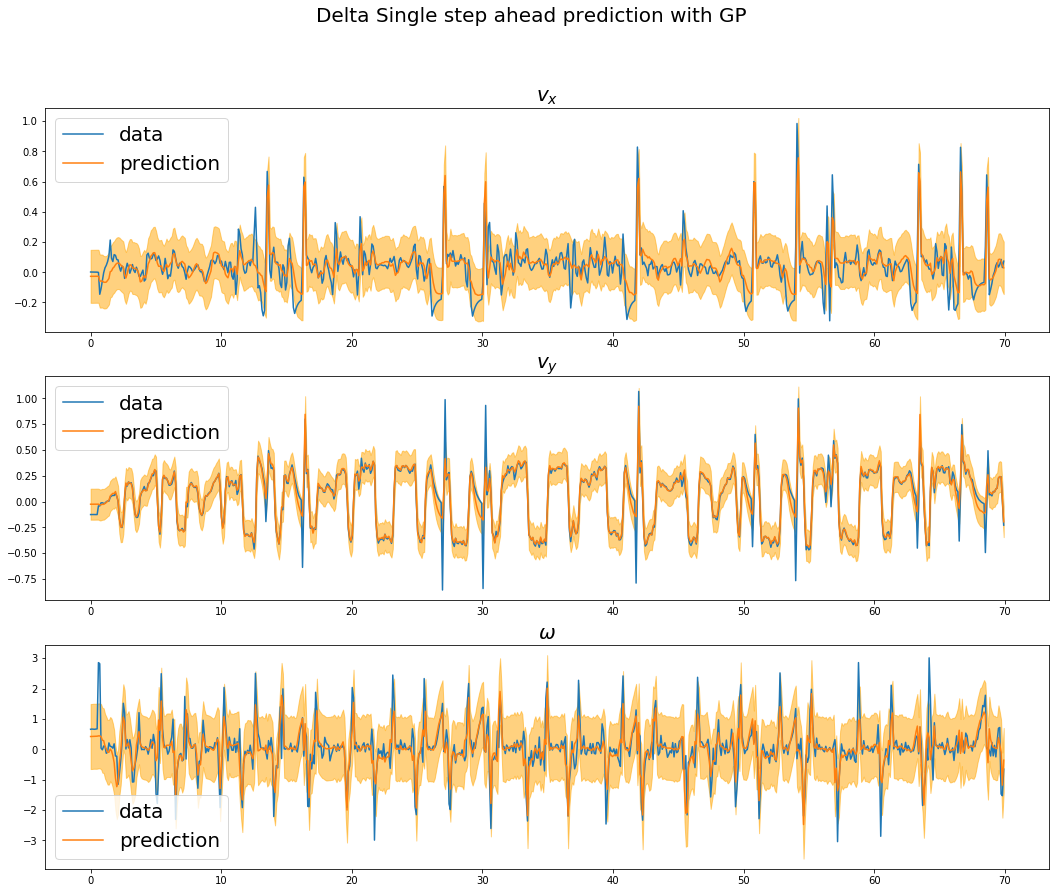

In [160]:
t_test = np.linspace(0, N_test*time_step, N_test)
print(N_test)
with torch.no_grad():
    # Initialize plot
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18,14))
    f.suptitle('Delta Single step ahead prediction with GP', fontsize=20)
    
    ax1.plot(t_test[:], test_y[:,0], label='data' )
    ax1.plot(t_test[:], sparse_GP.mean[:,0], label='prediction')
    ax1.legend(fontsize=20)
    ax1.fill_between(t_test, sparse_GP.lower[:,0], sparse_GP.upper[:,0], color='orange', alpha=0.5)
    ax1.set_title('$v_x$', fontsize=20)
    
    ax2.plot(t_test, test_y[:,1], label='data' )
    ax2.plot(t_test, sparse_GP.mean[:,1], label='prediction') 
    ax2.legend(fontsize=20)
    ax2.fill_between(t_test, sparse_GP.lower[:,1], sparse_GP.upper[:,1], color='orange', alpha=0.5)
    ax2.set_title('$v_y$', fontsize=20)
    
    ax3.plot(t_test, test_y[:,2], label='data')
    ax3.plot(t_test, sparse_GP.mean[:,2], label='prediction')
    ax3.legend(fontsize=20)
    ax3.fill_between(t_test, sparse_GP.lower[:,2], sparse_GP.upper[:,2], color='orange', alpha=0.5)
    ax3.set_title('$\\omega$ ', fontsize=20)
                  
    plt.savefig('pictures_4_thesis/sim/Delta_single_step_prediction.png',dpi=300)

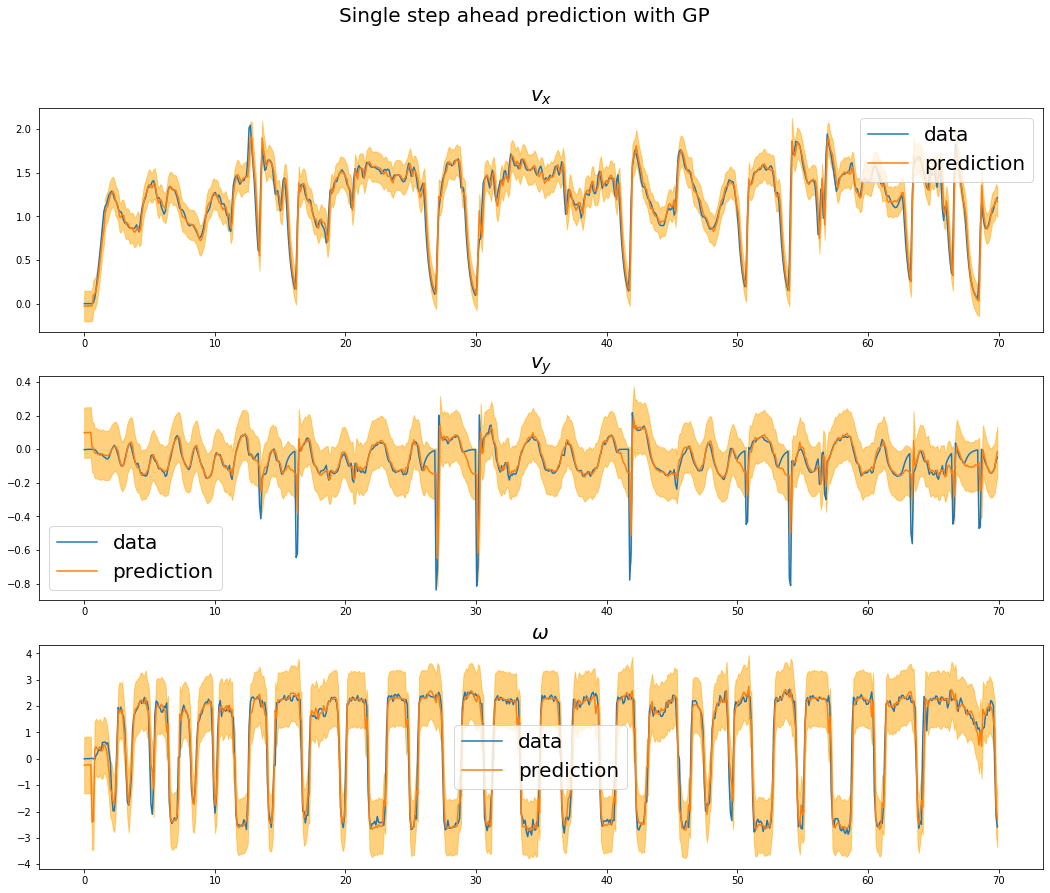

In [161]:
# with torch.no_grad():

#     plt.figure(figsize=(16,6))
#     plt.plot(t_test, x_next_test[:,0], label='$vel_x$ data', alpha=1)
#     plt.plot(t_test, sparse_GP.mean[:,0] + test_x[:,2].numpy(), label='$vel_x$ pred')
#     plt.xlabel('Time [s]')
#     plt.legend(fontsize=20)
#     plt.fill_between(t_test, sparse_GP.lower[:,0] + test_x[:,2].numpy(), sparse_GP.upper[:,0] + test_x[:,2].numpy(), color='orange', alpha=0.5)
#     plt.grid(True)

#     plt.figure(figsize=(16,6))
#     plt.plot(t_test, x_next_test[:,1], label='$vel_y$ data', alpha=1)
#     plt.plot(t_test, sparse_GP.mean[:,1] + test_x[:,3].numpy(), label='$vel_y$ pred')
#     plt.xlabel('Time [s]')
#     plt.legend(fontsize=20)
#     plt.fill_between(t_test, sparse_GP.lower[:,1]+test_x[:,3].numpy(), sparse_GP.upper[:,1]+test_x[:,3].numpy(), color='orange', alpha=0.5)
#     plt.grid(True)
    
#     plt.figure(figsize=(16,6))
#     plt.plot(t_test, x_next_test[:,2], label='w data', alpha=1)
#     plt.plot(t_test, sparse_GP.mean[:,2] + test_x[:,4].numpy(), label='w pred')
#     plt.xlabel('Time [s]')
#     plt.legend(fontsize=20)
#     plt.fill_between(t_test, sparse_GP.lower[:,2]+test_x[:,4].numpy(), sparse_GP.upper[:,2]+test_x[:,4].numpy(), color='orange', alpha=0.5)
#     plt.grid(True)
    
    
with torch.no_grad():
    # Initialize plot
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18,14))
    f.suptitle('Single step ahead prediction with GP', fontsize=20)
    
    ax1.plot(t_test[:], x_next_test[:,0], label='data' )
    ax1.plot(t_test[:], sparse_GP.mean[:,0]+ f_nom_matrix[:,0].numpy(), label='prediction')
    ax1.legend(loc='upper right', fontsize=20)
    ax1.fill_between(t_test, sparse_GP.lower[:,0]+ f_nom_matrix[:,0].numpy(), sparse_GP.upper[:,0]+ f_nom_matrix[:,0].numpy(), color='orange', alpha=0.5)
    ax1.set_title('$v_x$', fontsize=20)
    
    ax2.plot(t_test, x_next_test[:,1], label='data' )
    ax2.plot(t_test, sparse_GP.mean[:,1]+f_nom_matrix[:,1].numpy(), label='prediction') 
    ax2.legend(fontsize=20)
    ax2.fill_between(t_test, sparse_GP.lower[:,1]+f_nom_matrix[:,1].numpy(), sparse_GP.upper[:,1]+f_nom_matrix[:,1].numpy(), color='orange', alpha=0.5)
    ax2.set_title('$v_y$', fontsize=20)
    
    ax3.plot(t_test, x_next_test[:,2], label='data')
    ax3.plot(t_test, sparse_GP.mean[:,2]+ f_nom_matrix[:,2].numpy(), label='prediction')
    ax3.legend(fontsize=20)
    ax3.fill_between(t_test, sparse_GP.lower[:,2]+ f_nom_matrix[:,2].numpy(), sparse_GP.upper[:,2]+ f_nom_matrix[:,2].numpy(), color='orange', alpha=0.5)
    ax3.set_title('$\\omega$ ', fontsize=20)
    
#     plt.savefig('pictures_4_thesis/sim/single_step_prediction.png',dpi=300)

# Metrics

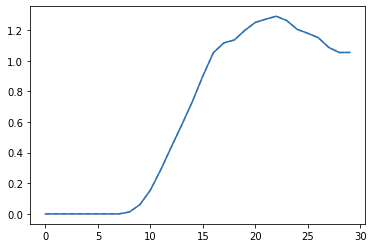

In [179]:
# sparse_GP.mean[:,2]
plt.plot(test_x[:30,2],'--', color='orchid', label='data')
plt.plot(vx_test[:30])

In [180]:
for ii in range(3):
#     train_pred_dist = sparse_GP.model[ii](test_x)
    train_pred_dist = sparse_GP.pred_dist[ii] 
    y_mean = sparse_GP.model[ii](test_x).mean.detach()
    nlpd = gpytorch.metrics.negative_log_predictive_density(train_pred_dist, test_y[:,ii]).detach().numpy()
    MSE = gpytorch.metrics.mean_squared_error(train_pred_dist, test_y[:,ii], squared=True).detach().numpy()
    MAE = gpytorch.metrics.mean_absolute_error(train_pred_dist, test_y[:,ii]).detach().numpy()
    print(f'nlpd: {nlpd: .2f}, MSE: {MSE: .3f}, MAE: {MAE: .3f}')

nlpd: -1.02, MSE:  0.008, MAE:  0.060
nlpd: -1.09, MSE:  0.007, MAE:  0.035
nlpd:  0.70, MSE:  0.235, MAE:  0.289


# Propagation

step 5  preds 5


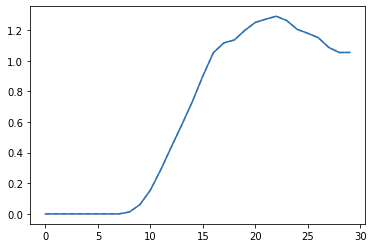

In [181]:
# test x: throttle / steering / v_x / v_y / w
# test y: delta_vx / delta_vy / delta_w

# n_pred = int(60/2) # number of step ahead prediction
n_pred = 30
max_tot_predictions = 5 # how many prediction period in the batch

if n_pred > len(test_x[:,0]):
    n_pred = len(test_x[:,0])-2
    
total_predictions = int(np.floor(len(test_x[:,0])/n_pred)) # actual number prediction period
total_predictions

if total_predictions >= max_tot_predictions:
    step = int(total_predictions/max_tot_predictions)+1
    preds = max_tot_predictions
else:
    step = 1
    preds = total_predictions
    
print('step', step, ' preds', preds)

plt.plot(test_x[:30,2],'--', color='orchid', label='data')
plt.plot(vx_test[:30])

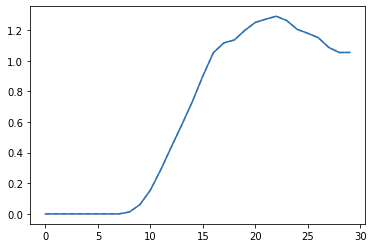

In [182]:
# store mean values predicted
long_prediction_vx = np.zeros([preds, n_pred])
long_prediction_vy = np.zeros([preds, n_pred])
long_prediction_w = np.zeros([preds, n_pred])
#
delta_long_prediction_vx = np.zeros([preds, n_pred])
delta_long_prediction_vy = np.zeros([preds, n_pred])
delta_long_prediction_w = np.zeros([preds, n_pred])
#
long_prediction_vx_global = np.zeros([preds, n_pred])
long_prediction_vy_global = np.zeros([preds, n_pred])
#
long_prediction_var_vx = np.zeros([preds, n_pred])
long_prediction_var_vy = np.zeros([preds, n_pred])
long_prediction_var_w = np.zeros([preds, n_pred])
#
nominal_prediction_vx = np.zeros([preds, n_pred])
nominal_prediction_vy = np.zeros([preds, n_pred])
nominal_prediction_w = np.zeros([preds, n_pred])
#
delta_nominal_prediction_vx = np.zeros([preds, n_pred])
delta_nominal_prediction_vy = np.zeros([preds, n_pred])
delta_nominal_prediction_w = np.zeros([preds, n_pred])
#
nominal_prediction_vx_global = np.zeros([preds, n_pred])
nominal_prediction_vy_global = np.zeros([preds, n_pred])
# store values for derived quantities
long_prediction_x = np.zeros([preds, n_pred])
long_prediction_y = np.zeros([preds, n_pred])
long_prediction_theta = np.zeros([preds, n_pred])
#
long_prediction_var_x = np.zeros([preds, n_pred])
long_prediction_var_y = np.zeros([preds, n_pred])
long_prediction_var_theta = np.zeros([preds, n_pred])
#
nominal_prediction_x = np.zeros([preds, n_pred])
nominal_prediction_y = np.zeros([preds, n_pred])
nominal_prediction_theta = np.zeros([preds, n_pred])

times_to_plot = np.zeros([preds, n_pred])




#
prediction_x_loc = np.zeros([preds, n_pred])
prediction_y_loc = np.zeros([preds, n_pred])
nominal_x_loc = np.zeros([preds, n_pred])
nominal_y_loc = np.zeros([preds, n_pred])

plt.plot(test_x[:30,2],'--', color='orchid', label='data')
plt.plot(vx_test[:30])

In [183]:
# type(tau_test)
type(long_prediction_vx)

numpy.ndarray

i 1 / 5
i 2 / 5
i 3 / 5
i 4 / 5
i 5 / 5


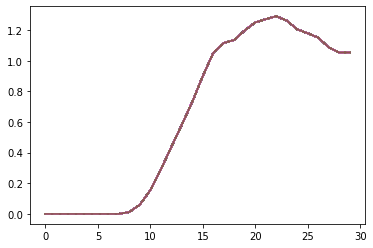

In [184]:
# test x: throttle / steering / v_x / v_y / w
#             0         1        2     3    4
for i in range(preds):
    
    print('i', i+1, '/', preds)
    
    x0_pred = test_x[ int(i*step*n_pred):int(i*step*n_pred+1), :]
    x0_pred = torch.autograd.Variable(torch.Tensor(x0_pred), requires_grad=True)

    
    long_prediction_vx[i, 0] = x0_pred[0, 2]
    long_prediction_vy[i, 0] = x0_pred[0, 3]
    long_prediction_w[i, 0] = x0_pred[0, 4]
    
#     delta_long_prediction_vx[i, 0] = test_y[ int(i*step*n_pred):int(i*step*n_pred+1), 0]
#     delta_long_prediction_vy[i, 0] = test_y[ int(i*step*n_pred):int(i*step*n_pred+1), 1]
#     delta_long_prediction_w[i, 0] = test_y[ int(i*step*n_pred):int(i*step*n_pred+1), 2]

#     delta_long_prediction_vx[i, 0] = 0
#     delta_long_prediction_vy[i, 0] = 0
#     delta_long_prediction_w[i, 0] = 0
    
    long_prediction_x[i, 0] = X_test[int(i*step*n_pred):int(i*step*n_pred+1)]
    long_prediction_y[i, 0] = Y_test[int(i*step*n_pred):int(i*step*n_pred+1)]
    long_prediction_theta[i, 0] = theta_test[int(i*step*n_pred):int(i*step*n_pred+1)]
    
    long_prediction_vx_global[i, 0] = long_prediction_vx[i,0]*np.cos(long_prediction_theta[i,0]) - long_prediction_vy[i,0]*np.sin(long_prediction_theta[i,0])
    long_prediction_vy_global[i, 0] = long_prediction_vx[i,0]*np.sin(long_prediction_theta[i,0]) + long_prediction_vy[i,0]*np.cos(long_prediction_theta[i,0])

 
    
    nominal_prediction_vx[i, 0] = x0_pred[0, 2]
    nominal_prediction_vy[i, 0] = x0_pred[0, 3]
    nominal_prediction_w[i, 0] = x0_pred[0, 4]
    
    nominal_prediction_x[i, 0] = X_test[int(i*step*n_pred):int(i*step*n_pred+1)]
    nominal_prediction_y[i, 0] = Y_test[int(i*step*n_pred):int(i*step*n_pred+1)]
    nominal_prediction_theta[i, 0] = theta_test[int(i*step*n_pred):int(i*step*n_pred+1)] 
    
    nominal_prediction_vx_global[i,0] = nominal_prediction_vx[i,0]*np.cos(nominal_prediction_theta[i,0]) - nominal_prediction_vy[i,0]*np.sin(nominal_prediction_theta[i,0])
    nominal_prediction_vy_global[i,0] = nominal_prediction_vx[i,0]*np.sin(nominal_prediction_theta[i,0]) + nominal_prediction_vy[i,0]*np.cos(nominal_prediction_theta[i,0])
    
    
#     prediction_x_loc[i, 0] = x[int(i*step*n_pred):int(i*step*n_pred+1)]
#     prediction_y_loc[i, 0] = y[int(i*step*n_pred):int(i*step*n_pred+1)]
#     nominal_x_loc[i, 0] = x[int(i*step*n_pred):int(i*step*n_pred+1)]
#     nominal_y_loc[i, 0] = y[int(i*step*n_pred):int(i*step*n_pred+1)]
    
    
#     nominal_prediction_x[i, 0] = data_numpy_test[int(i*step*n_pred):int(i*step*n_pred+1), 10] 
#     nominal_prediction_y[i, 0] = data_numpy_test[int(i*step*n_pred):int(i*step*n_pred+1), 11]
#     nominal_prediction_theta[i, 0] = data_numpy_test[int(i*step*n_pred):int(i*step*n_pred+1), 12] 
    
    
    times_to_plot[i, :] = t_test[ int(i*step*n_pred):int(i*step*n_pred+n_pred) ]
    
#     covar_x = np.array(np.zeros([3,3])) # reset uncertainties on the states to 0
#     covar_vth = np.array(np.zeros([3,3])) # for derived quantities
    dt = 0.1
    
    for k in range(1, n_pred):
        
        plt.plot(test_x[:30,2],'--', color='orchid', label='data')
        plt.plot(vx_test[:30])
        
        vx_single_step_prediction = sparse_GP.likelihood[0](sparse_GP.model[0](x0_pred))
        mean_vx_pred = vx_single_step_prediction.mean.cpu()
#         dvx_x = torch.autograd.grad(vx_single_step_prediction.mean, x0_pred)[0].cpu().numpy()

        
        vy_single_step_prediction = sparse_GP.likelihood[1](sparse_GP.model[1](x0_pred))
        mean_vy_pred = vy_single_step_prediction.mean
#         dvy_x = torch.autograd.grad(vy_single_step_prediction.mean, x0_pred)[0].cpu().numpy()
        
        w_single_step_prediction = sparse_GP.likelihood[2](sparse_GP.model[2](x0_pred))
        mean_w_pred = w_single_step_prediction.mean
#         dw_x = torch.autograd.grad(w_single_step_prediction.mean, x0_pred)[0].cpu().numpy()
        
        
        f_n = nominal_dynamics(x0_pred[0,0].detach(), x0_pred[0,1].detach(), long_prediction_vx[i,k-1], long_prediction_vy[i,k-1], long_prediction_w[i,k-1])
        f_n_nom = nominal_dynamics(x0_pred[0,0].detach(), x0_pred[0,1].detach(), nominal_prediction_vx[i,k-1], nominal_prediction_vy[i,k-1], nominal_prediction_w[i,k-1])
        
        
        long_prediction_theta[i, k] = long_prediction_theta[i, k-1] + long_prediction_w[i, k-1]*dt
        nominal_prediction_theta[i, k] = nominal_prediction_theta[i, k-1] + nominal_prediction_w[i, k-1] * dt

#         if long_prediction_theta[i, k] > np.pi :
#             long_prediction_theta[i, k] = long_prediction_theta[i, k] - 2*np.pi
#         if nominal_prediction_theta[i, k] > np.pi :
#             nominal_prediction_theta[i, k] = nominal_prediction_theta[i, k] - 2*np.pi
#         if long_prediction_theta[i, k] < -np.pi :
#             long_prediction_theta[i, k] = long_prediction_theta[i, k] + 2*np.pi
#         if nominal_prediction_theta[i, k] < -np.pi :
#             nominal_prediction_theta[i, k] = nominal_prediction_theta[i, k] + 2*np.pi
        
        
        long_prediction_vx[i, k] = mean_vx_pred.detach().numpy() + f_n[0,0].detach().numpy()
        long_prediction_vy[i, k] = mean_vy_pred.detach().numpy() + f_n[0,1].detach().numpy()
        long_prediction_w[i, k] = mean_w_pred.detach().numpy() + f_n[0,2].detach().numpy()
        
#         print(x0_pred[0, 2])
        
        delta_long_prediction_vx[i, k] = mean_vx_pred.detach().numpy() 
        delta_long_prediction_vy[i, k] = mean_vy_pred.detach().numpy() 
        delta_long_prediction_w[i, k] = mean_w_pred.detach().numpy()  
        
        long_prediction_vx_global[i,k] = long_prediction_vx[i,k]*np.cos(long_prediction_theta[i,k]) - long_prediction_vy[i,k]*np.sin(long_prediction_theta[i,k])
        long_prediction_vy_global[i,k] = long_prediction_vx[i,k]*np.sin(long_prediction_theta[i,k]) + long_prediction_vy[i,k]*np.cos(long_prediction_theta[i,k])

        long_prediction_x[i, k] = long_prediction_x[i, k-1] + long_prediction_vx_global[i, k-1]*dt
        long_prediction_y[i, k] = long_prediction_y[i, k-1] + long_prediction_vy_global[i, k-1]*dt
        
        
        nominal_prediction_vx[i, k] = f_n_nom[0,0].detach().numpy()
        nominal_prediction_vy[i, k] = f_n_nom[0,1].detach().numpy()
        nominal_prediction_w[i, k] = f_n_nom[0,2].detach().numpy()
        
        nominal_prediction_vx_global[i,k] = nominal_prediction_vx[i,k]*np.cos(nominal_prediction_theta[i,k]) - nominal_prediction_vy[i,k]*np.sin(nominal_prediction_theta[i,k])
        nominal_prediction_vy_global[i,k] = nominal_prediction_vx[i,k]*np.sin(nominal_prediction_theta[i,k]) + nominal_prediction_vy[i,k]*np.cos(nominal_prediction_theta[i,k])

        nominal_prediction_x[i, k] = nominal_prediction_x[i, k-1] + nominal_prediction_vx_global[i,k-1] * dt
        nominal_prediction_y[i, k] = nominal_prediction_y[i, k-1] + nominal_prediction_vy_global[i,k-1] * dt
        
        #### note that X and Y position are the one in the inertial fixed reference frame (GLOBAL)
        
#         prediction_x_loc[i, k] = prediction_x_loc[i, k-1] + long_prediction_vx[i,k-1]*dt
#         prediction_y_loc[i, k] = prediction_y_loc[i, k-1] + long_prediction_vy[i,k-1]*dt
#         nominal_x_loc[i, k] = nominal_x_loc[i, k-1] + nominal_prediction_vx[i,k-1]*dt
#         nominal_y_loc[i, k] = nominal_y_loc[i, k-1] + nominal_prediction_vy[i,k-1]*dt
        
        
        
#         covar_x_from_GP = np.zeros([3,3])
#         covar_x_from_GP[0,0] = vx_single_step_prediction.covariance_matrix.item()
#         covar_x_from_GP[1,1] = vy_single_step_prediction.covariance_matrix.item()
#         covar_x_from_GP[2,2] = w_single_step_prediction.covariance_matrix.item()
        
#         A = np.vstack((dvx_x, dvy_x, dw_x))
        
#         dummy_covar = np.array(np.zeros([5, 5]))
#         dummy_covar[2, 2] = covar_x[0, 0]
#         dummy_covar[3, 3] = covar_x[1, 1]
#         dummy_covar[4, 4] = covar_x[2, 2]

#         covar_x = covar_x + np.matmul(A, np.matmul(dummy_covar, np.transpose(A))) + covar_x_from_GP
#         covar_vth = covar_vth + covar_x * dt **2 # ???????????????????????????????????????????????????????
#         print('covar x ', covar_x, 'covar vth ', covar_vth)
        
#         long_prediction_var_vx[i, k] = covar_x[0,0]
#         long_prediction_var_vy[i, k] = covar_x[1,1]
#         long_prediction_var_w[i, k] = covar_x[2,2]
        
#         long_prediction_var_x[i, k] = covar_vth[0,0]
#         long_prediction_var_y[i, k] = covar_vth[1,1]
#         long_prediction_var_theta[i, k] = covar_vth[2,2]     



        tau_next = tau_test[ int(i*step*n_pred+k) ]

        steer_next = steer_test[ int(i*step*n_pred+k):int(i*step*n_pred+k+1) ]
        vx_next = long_prediction_vx[i, k]
        vy_next = long_prediction_vy[i, k]
        w_next = long_prediction_w[i, k]

        
        x0_pred = torch.tensor([ [ tau_next, steer_next, vx_next, vy_next, w_next ] ])

#         x0_pred = test_x[ int(i*step*n_pred+k):int(i*step*n_pred+k+1), :]
        
#         x0_pred = torch.hstack((x0_pred, torch.tensor(long_prediction_vx[i, k])))
#         x0_pred[0, 2] = long_prediction_vx[i, k]
#         x0_pred[0, 3] = long_prediction_vy[i, k]
#         x0_pred[0, 4] = long_prediction_w[i, k]
        
#         x0_pred = torch.autograd.Variable(torch.Tensor(x0_pred), requires_grad=True)

        
plt.plot(test_x[:30,2],'--', color='orchid', label='data')
plt.plot(vx_test[:30])

In [185]:
x0_pred

tensor([[ 0.2000,  0.3290,  1.4381, -0.1343,  2.2627]], dtype=torch.float64)

In [186]:
vx_single_step_prediction.covariance_matrix.item()

0.00735829805098788

In [187]:
test_x[0,:].shape

torch.Size([5])

In [188]:
x_next_test.shape

torch.Size([699, 3])

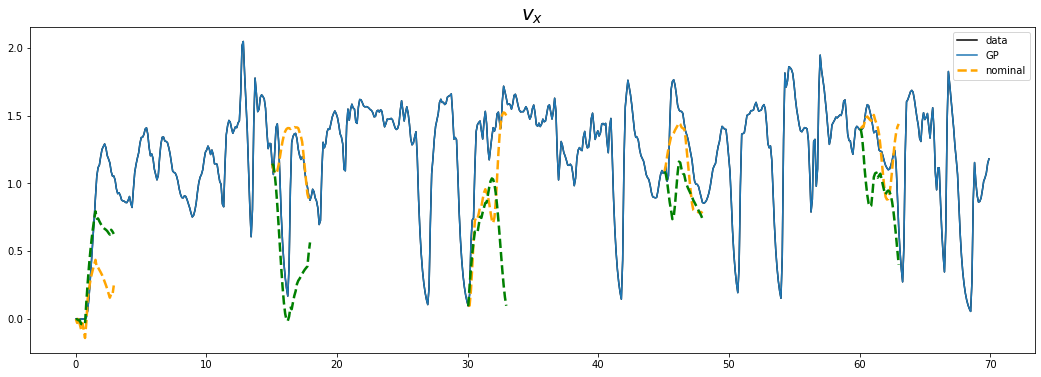

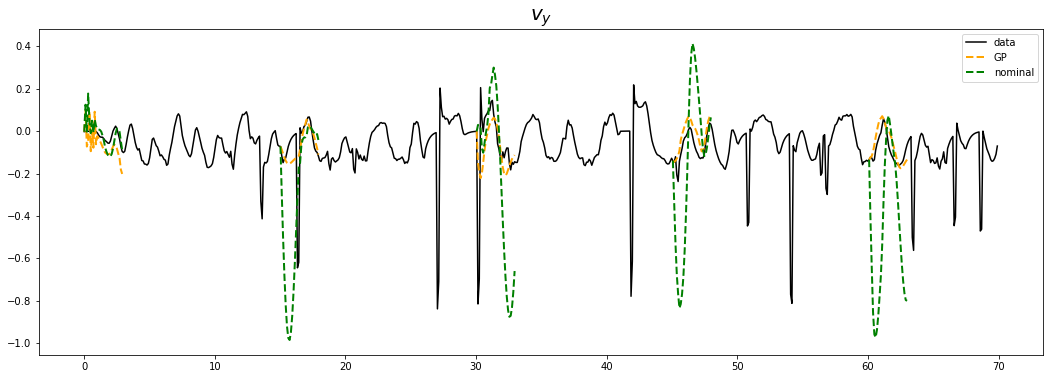

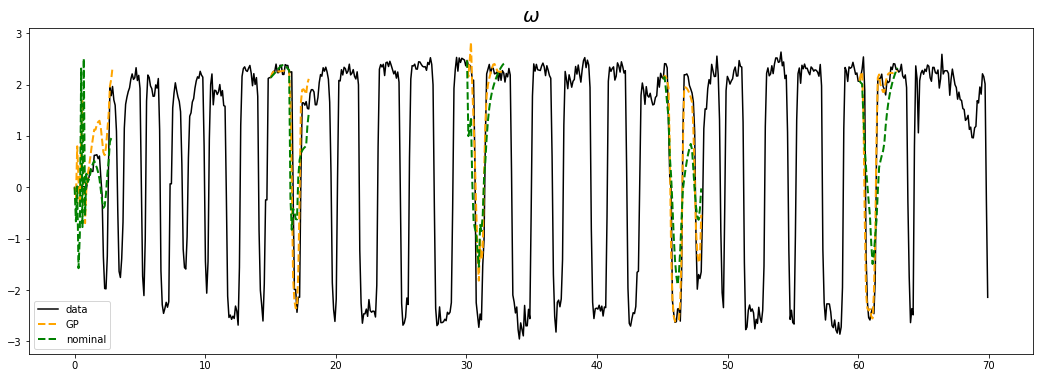

In [189]:
# test_x = torch.tensor(data_numpy_test[:-1, train_inputs_indexes])
# x_next_test = torch.tensor(data_numpy_test[1:, train_outputs_indexes])

#             0       1      2      3     4         
#         throttle  steer   vx     vy     w  

data_vx = np.concatenate( ( test_x[0,2], x_next_test[:,0] ) , axis=None)
data_vy = np.concatenate( ( test_x[0,3], x_next_test[:,1] ) , axis=None)
data_w = np.concatenate( ( test_x[0,4], x_next_test[:,2] ) , axis=None)

plt.figure(figsize=(18,6))
plt.title('$v_x$', fontsize=20)
plt.plot(t_test, data_vx[:-1], color='black')
plt.plot(t_test, test_x[:,2])
for i in range(preds):
    plt.plot(times_to_plot[i,:], long_prediction_vx[i,:], linewidth=2.5, linestyle='dashed', color='orange')
    plt.plot(times_to_plot[i,:], nominal_prediction_vx[i,:], linewidth=2.5, linestyle='dashed', color='green')   
#     plt.fill_between(times_to_plot[i,:], -2*np.sqrt(long_prediction_var_vx[i])+nominal_prediction_vx[i,:], 2*np.sqrt(long_prediction_var_vx[i])+nominal_prediction_vx[i,:], alpha=0.5, color='orchid')
    plt.legend(['data','GP','nominal'])
#     plt.xlim((0,100))
#     plt.ylim((-2, 2))
# plt.savefig('VX_prediction.png')


plt.figure(figsize=(18,6))
plt.title('$v_y$', fontsize=20)
plt.plot(t_test, data_vy[:-1], color='black')
for i in range(preds):
    plt.plot(times_to_plot[i,:], long_prediction_vy[i,:], linewidth=2,linestyle='dashed', color='orange')
    plt.plot(times_to_plot[i,:], nominal_prediction_vy[i,:], linewidth=2,linestyle='dashed', color='green')     
#     plt.fill_between(times_to_plot[i,:], -2*np.sqrt(long_prediction_var_vy[i])+nominal_prediction_vy[i,:], 2*np.sqrt(long_prediction_var_vy[i])+nominal_prediction_vy[i,:], alpha=0.5, color='orchid')
    plt.legend(['data','GP','nominal'])
#     plt.xlim((0, 100))
#     plt.ylim((-3, 3))

        
plt.figure(figsize=(18,6))
plt.title('$\omega$', fontsize=20)
plt.plot(t_test, data_w[:-1], color='black')
for i in range(preds):
    plt.plot(times_to_plot[i,:], long_prediction_w[i,:], linewidth=2,linestyle='dashed', color='orange')
    plt.plot(times_to_plot[i,:], nominal_prediction_w[i,:], linewidth=2,linestyle='dashed', color='green')    
#     plt.fill_between(times_to_plot[i,:], -2*np.sqrt(long_prediction_var_w[i])+nominal_prediction_w[i,:], 2*np.sqrt(long_prediction_var_w[i])+nominal_prediction_w[i,:], alpha=0.5, color='orchid')
    plt.legend(['data','GP','nominal'])
#     plt.xlim((0, 100))
#     plt.ylim((-3, 3))

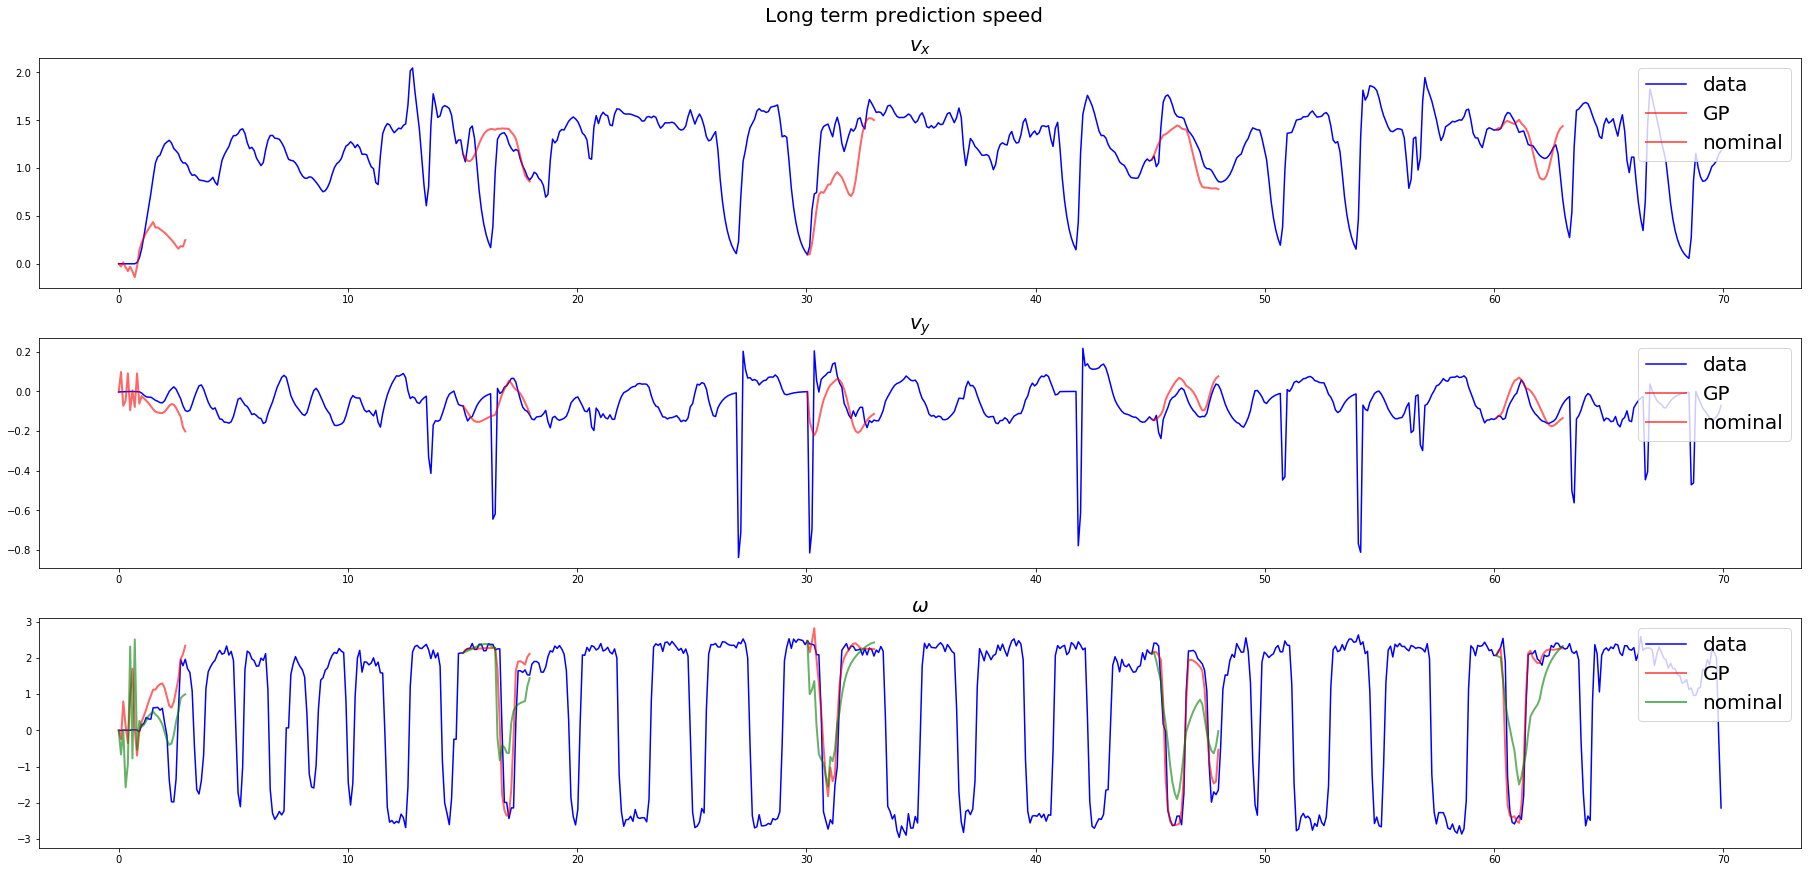

In [190]:
N = len(train_x)
t = np.linspace(0, N*time_step, N)

# fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(25, 12), constrained_layout=True)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(25, 12), constrained_layout=True)
fig.suptitle('Long term prediction speed',fontsize=20)

# ax1.set_title('Train $v_x$')
# ax1.plot(t, train_x[:,2], color='blue')

# ax3.set_title('Train $v_y$')
# ax3.plot(t, train_x[:,3], color='blue')

# ax5.set_title('Train $\omega$')
# ax5.plot(t, train_x[:,4], color='blue')


ax1.set_title('$v_x$',fontsize=20)
ax1.plot(t_test, data_vx[:-1], color='blue')
# ax1.plot(t_test, vx_test[:-1], color='orchid', linewidth=2)
for i in range(preds):
    ax1.plot(times_to_plot[i,:], long_prediction_vx[i,:], linewidth=2, color='red', alpha=0.6)
#     ax2.fill_between(times_to_plot[i,:], -2*np.sqrt(long_prediction_var_vx[i])+nominal_prediction_vx[i,:], 2*np.sqrt(long_prediction_var_vx[i])+nominal_prediction_vx[i,:], alpha=0.5, color='orchid')
#     ax2.set_xlim((0, 120))
#     ax1.plot(times_to_plot[i,:], nominal_prediction_vx[i,:], linewidth=2,color='green', alpha=0.6)
ax1.legend(['data','GP','nominal'],fontsize=20, loc='upper right')

ax2.set_title('$v_y$',fontsize=20)
ax2.plot(t_test, data_vy[:-1], color='blue')
for i in range(preds):
    ax2.plot(times_to_plot[i,:], long_prediction_vy[i,:],  linewidth=2, color='red', alpha=0.6)
#     ax4.fill_between(times_to_plot[i,:], -2*np.sqrt(long_prediction_var_vy[i])+nominal_prediction_vy[i,:], 2*np.sqrt(long_prediction_var_vy[i])+nominal_prediction_vy[i,:], alpha=0.5, color='orchid')
#     ax4.set_xlim((0, 120))
#     ax2.plot(times_to_plot[i,:], nominal_prediction_vy[i,:], linewidth=2,color='green', alpha=0.6)
ax2.legend(['data','GP','nominal'],fontsize=20, loc='upper right')

ax3.set_title('$\\omega$',fontsize=20)
ax3.plot(t_test, data_w[:-1], color='blue')
for i in range(preds):
    ax3.plot(times_to_plot[i,:], long_prediction_w[i,:],  linewidth=2, color='red', alpha=0.6)
#     ax6.fill_between(times_to_plot[i,:], -2*np.sqrt(long_prediction_var_w[i])+nominal_prediction_w[i,:], 2*np.sqrt(long_prediction_var_w[i])+nominal_prediction_w[i,:], alpha=0.5, color='orchid')
#     ax6.set_xlim((0, 120))
    ax3.plot(times_to_plot[i,:], nominal_prediction_w[i,:], linewidth=2,color='green', alpha=0.6)
ax3.legend(['data','GP','nominal'],fontsize=20, loc='upper right')

plt.savefig('pictures_4_thesis/sim/Multi_step_prediction_SPEED.png',dpi=300)


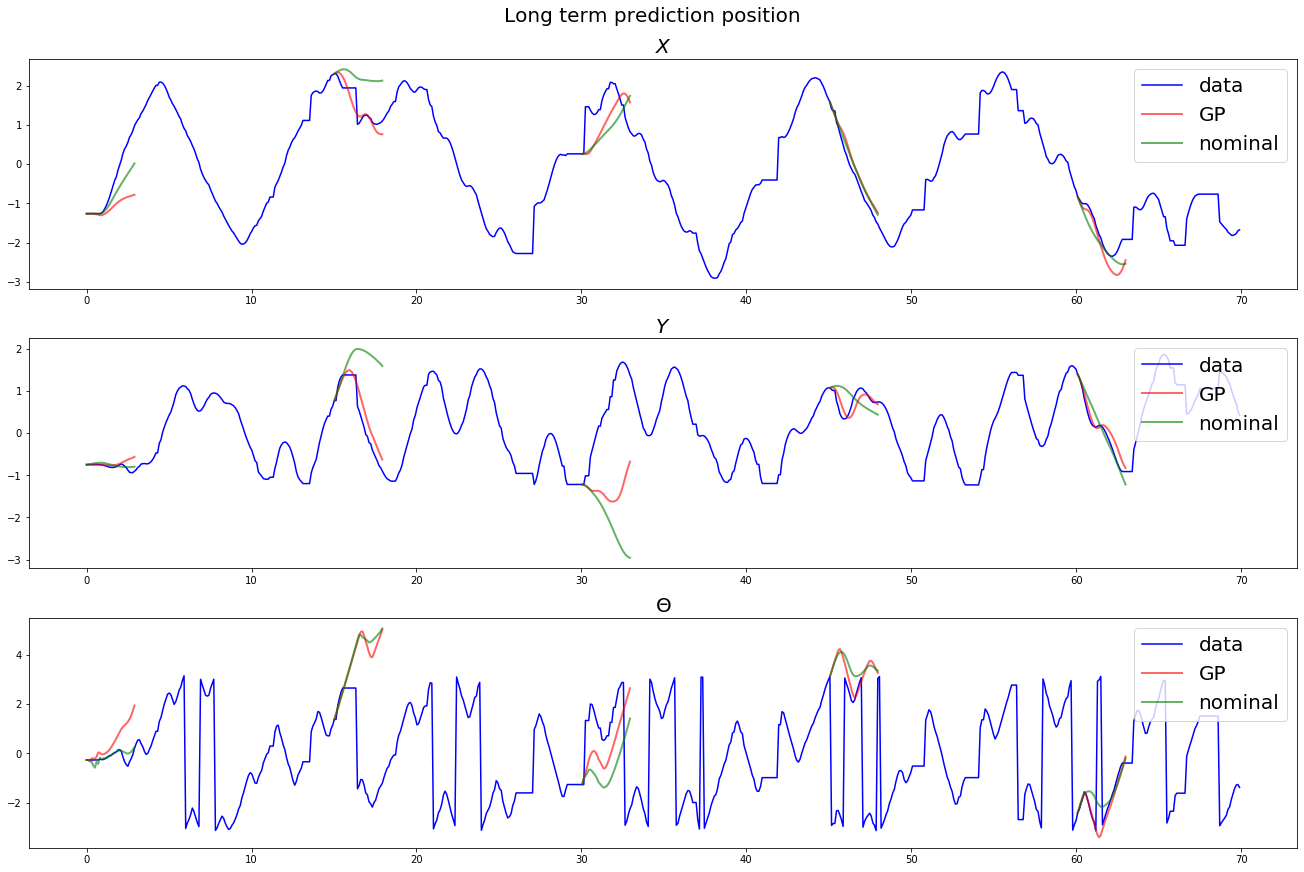

In [191]:
fig, ((ax1, ax2, ax3)) = plt.subplots(3, 1, figsize=(18, 12), constrained_layout=True)
fig.suptitle('Long term prediction position',fontsize=20)

ax1.set_title('$X$',fontsize=20)
ax1.plot(t_test, X_test[:-1], color='blue')
for i in range(preds):
    ax1.plot(times_to_plot[i,:], long_prediction_x[i,:], linewidth=2, color='red', alpha=0.6)
#     ax2.fill_between(times_to_plot[i,:], -2*np.sqrt(long_prediction_var_vx[i])+nominal_prediction_vx[i,:], 2*np.sqrt(long_prediction_var_vx[i])+nominal_prediction_vx[i,:], alpha=0.5, color='orchid')
#     ax2.set_xlim((0, 120))
    ax1.plot(times_to_plot[i,:], nominal_prediction_x[i,:], linewidth=2,color='green', alpha=0.6)
ax1.legend(['data','GP','nominal'],fontsize=20, loc='upper right')

ax2.set_title('$Y$', fontsize=20)
ax2.plot(t_test, Y_test[:-1], color='blue')
for i in range(preds):
    ax2.plot(times_to_plot[i,:], long_prediction_y[i,:],  linewidth=2, color='red', alpha=0.6)
#     ax4.fill_between(times_to_plot[i,:], -2*np.sqrt(long_prediction_var_vy[i])+nominal_prediction_vy[i,:], 2*np.sqrt(long_prediction_var_vy[i])+nominal_prediction_vy[i,:], alpha=0.5, color='orchid')
#     ax4.set_xlim((0, 120))
    ax2.plot(times_to_plot[i,:], nominal_prediction_y[i,:], linewidth=2,color='green', alpha=0.6)
ax2.legend(['data','GP','nominal'],fontsize=20, loc='upper right')

ax3.set_title('$\Theta$', fontsize=20)
ax3.plot(t_test, theta_test[:-1], color='blue')
for i in range(preds):
    ax3.plot(times_to_plot[i,:], long_prediction_theta[i,:],  linewidth=2, color='red', alpha=0.6)
#     ax6.fill_between(times_to_plot[i,:], -2*np.sqrt(long_prediction_var_w[i])+nominal_prediction_w[i,:], 2*np.sqrt(long_prediction_var_w[i])+nominal_prediction_w[i,:], alpha=0.5, color='orchid')
#     ax6.set_xlim((0, 120))
    ax3.plot(times_to_plot[i,:], nominal_prediction_theta[i,:], linewidth=2,color='green', alpha=0.6)
ax3.legend(['data','GP','nominal'],fontsize=20, loc='upper right')

plt.savefig('pictures_4_thesis/sim/Multi_step_prediction_POSITION.png',dpi=300)

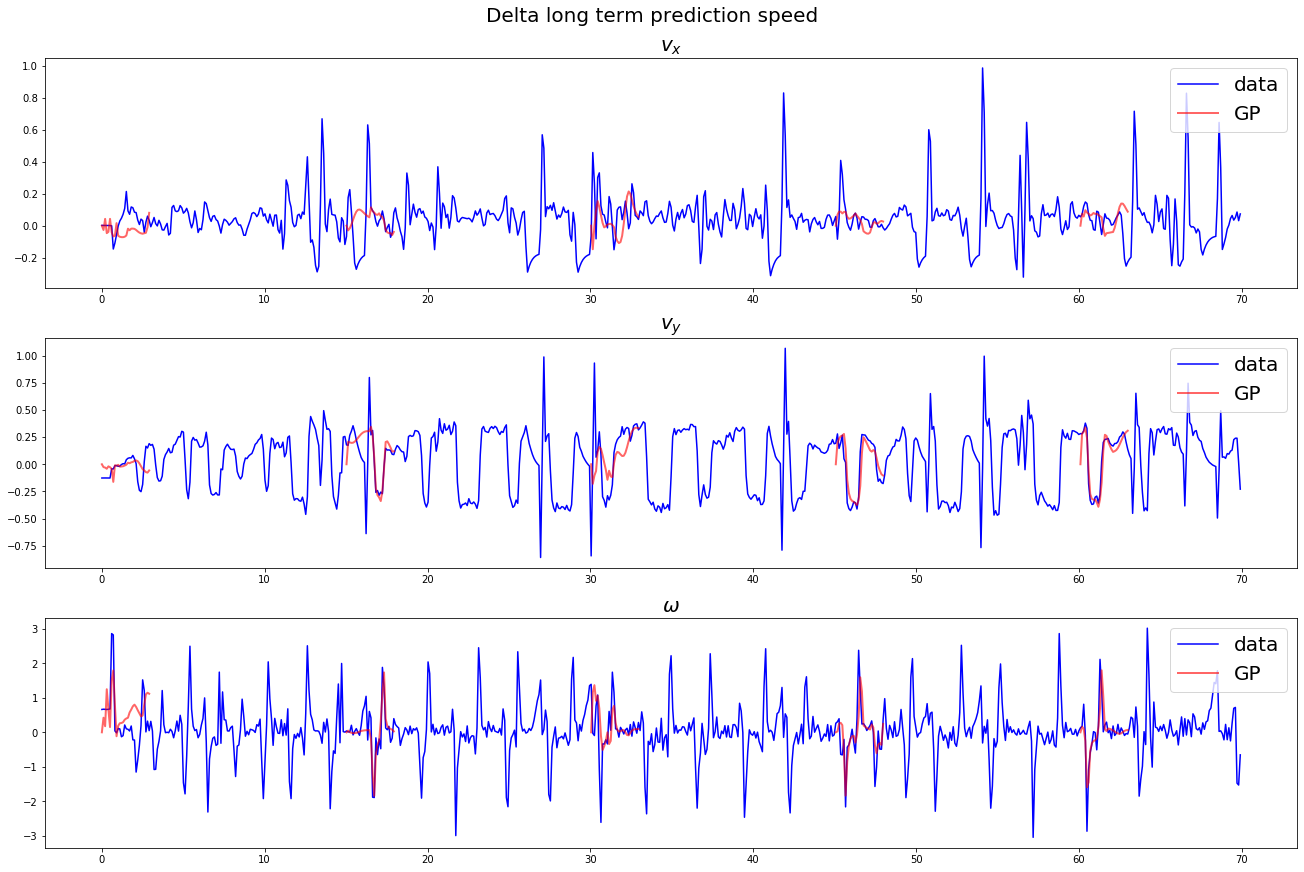

In [175]:
fig, ((ax1, ax2, ax3)) = plt.subplots(3, 1, figsize=(18, 12), constrained_layout=True)
fig.suptitle('Delta long term prediction speed',fontsize=20)

ax1.set_title('$v_x$',fontsize=20)
ax1.plot(t_test, test_y[:,0], color='blue')
for i in range(preds):
    ax1.plot(times_to_plot[i,:], delta_long_prediction_vx[i,:], linewidth=2, color='red', alpha=0.6)
#     ax2.fill_between(times_to_plot[i,:], -2*np.sqrt(long_prediction_var_vx[i])+nominal_prediction_vx[i,:], 2*np.sqrt(long_prediction_var_vx[i])+nominal_prediction_vx[i,:], alpha=0.5, color='orchid')
#     ax2.set_xlim((0, 120))
#     ax1.plot(times_to_plot[i,:], nominal_prediction_vx[i,:], linewidth=2,color='green', alpha=0.6)
ax1.legend(['data','GP'],fontsize=20, loc='upper right')

ax2.set_title('$v_y$',fontsize=20)
ax2.plot(t_test, test_y[:,1], color='blue')
for i in range(preds):
    ax2.plot(times_to_plot[i,:], delta_long_prediction_vy[i,:],  linewidth=2, color='red', alpha=0.6)
#     ax4.fill_between(times_to_plot[i,:], -2*np.sqrt(long_prediction_var_vy[i])+nominal_prediction_vy[i,:], 2*np.sqrt(long_prediction_var_vy[i])+nominal_prediction_vy[i,:], alpha=0.5, color='orchid')
#     ax4.set_xlim((0, 120))
#     ax2.plot(times_to_plot[i,:], nominal_prediction_vy[i,:], linewidth=2,color='green', alpha=0.6)
ax2.legend(['data','GP'],fontsize=20, loc='upper right')

ax3.set_title('$\omega$',fontsize=20)
ax3.plot(t_test, test_y[:,2], color='blue')
for i in range(preds):
    ax3.plot(times_to_plot[i,:], delta_long_prediction_w[i,:],  linewidth=2, color='red', alpha=0.6)
#     ax6.fill_between(times_to_plot[i,:], -2*np.sqrt(long_prediction_var_w[i])+nominal_prediction_w[i,:], 2*np.sqrt(long_prediction_var_w[i])+nominal_prediction_w[i,:], alpha=0.5, color='orchid')
#     ax6.set_xlim((0, 120))
#     ax3.plot(times_to_plot[i,:], nominal_prediction_w[i,:], linewidth=2,color='green', alpha=0.6)
ax3.legend(['data','GP'],fontsize=20, loc='upper right')

# plt.savefig('pictures_4_thesis/model/high/Delta_Multi_step_prediction_SPEED.png',dpi=300)

In [176]:
print(delta_long_prediction_vx[0,:])
print(long_prediction_vx[0,:])

[ 0.         -0.02681585  0.04250459 -0.04657437 -0.03865715  0.0426661
 -0.04098427 -0.06701819 -0.06305665  0.01591308 -0.06306924 -0.06908116
 -0.07143166 -0.07171494 -0.06904068 -0.06127557 -0.01876998 -0.02852943
 -0.01855263 -0.01821091 -0.01988952 -0.02673088 -0.03586606 -0.04317209
 -0.04787118 -0.05013135 -0.04705335 -0.04440505 -0.00986587  0.08027657]
[ 0.         -0.02861587  0.01496065 -0.03806874 -0.07617406 -0.03055588
 -0.07941626 -0.13948626 -0.02776022  0.14354701  0.21876682  0.27765225
  0.32537665  0.36500034  0.40038417  0.43635361  0.3786502   0.37970522
  0.36168409  0.34439457  0.32516149  0.30170396  0.27539364  0.24927712
  0.22119429  0.18764932  0.15724917  0.18501838  0.17906998  0.24760032]


In [177]:
# from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import mean_squared_error
# # from sklearn.metrics import negative_log_predictive_density

# batch_size_list = [ 25, 50, 100]
# n_epochs_list = [ 20, 40, 50, 60]
# for ii in batch_size_list:
#     for jj in n_epochs_list:
#         sparse_gp = SparseGPy(train_x, train_y, test_x, ii, jj)
#         sparse_gp.train()
#         sparse_gp.prediction()
#         pred_dist = sparse_gp.pred_dist
#         y_mean = sparse_gp.mean
#         MAE = mean_absolute_error(y_mean, test_y)
#         MSE = mean_squared_error(y_mean, test_y) 
#         nlpd = []
#         for k in range(train_y.shape[-1]):            
#             nlpd.append(gpytorch.metrics.negative_log_predictive_density(train_pred_dist[k], test_y[:,k]).detach().numpy().item())
#         nlpd = np.mean(nlpd)
#         print(f'batch_size: {ii}, n_epochs: {jj}, MAE: {MAE: .4f}, MSE: {MSE: .4f}, nlpd: {nlpd: .4f}')

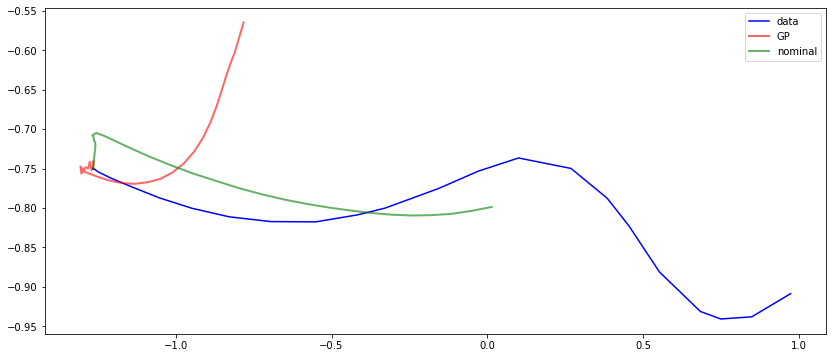

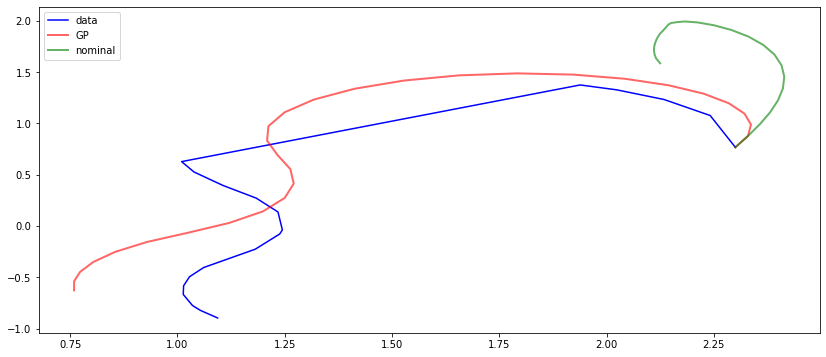

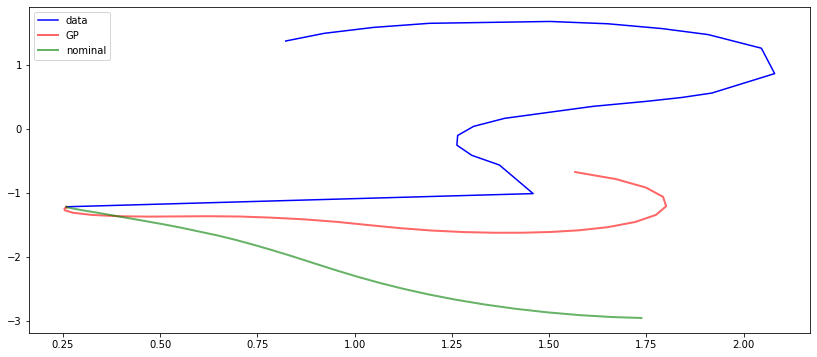

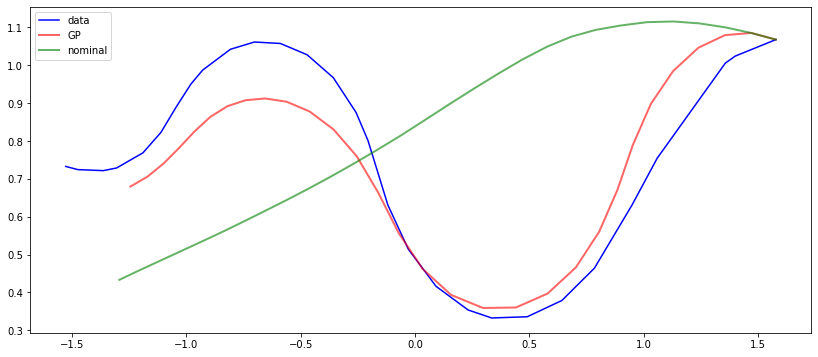

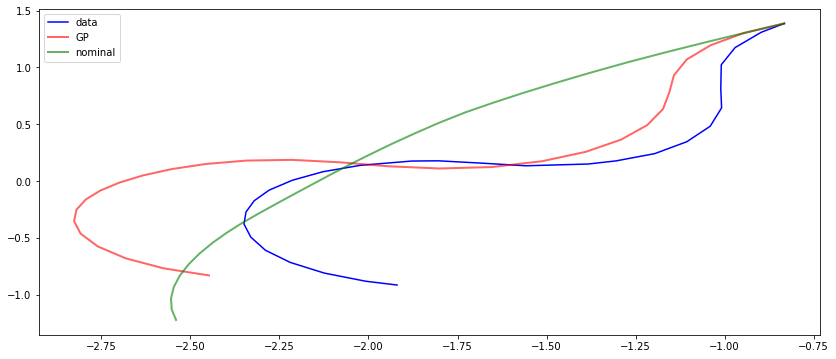

In [178]:
for i in range(preds):
    plt.figure(figsize=(14, 6))
    plt.plot(X_test[int(i*step*n_pred):int(i*step*n_pred+n_pred)],Y_test[int(i*step*n_pred):int(i*step*n_pred+n_pred)], color='blue')
    plt.plot(long_prediction_x[i,:], long_prediction_y[i,:], linewidth=2, color='red', alpha=0.6)
    plt.plot(nominal_prediction_x[i,:], nominal_prediction_y[i,:], linewidth=2,color='green', alpha=0.6)
    plt.legend(['data','GP','nominal'])
#     plt.xlim((-4,4))
#     plt.ylim((-3,3))